# Mental Health in the Tech Industry

## Imports

### Python modules

In [1]:
import subprocess

import zipfile

import sqlite3

import numpy as np
import pandas as pd

from statsmodels.graphics.mosaicplot import mosaic
import statsmodels.api as sm
from scipy.stats import chi2_contingency

import matplotlib.pyplot as plt
import seaborn as sns


from utils import (
    get_unique_values_from_dict,
    order_combined_value,
    standardize_values,
    get_matching_value_counts,
    assess_and_convert_combined_into_single_value,
)

from standardized_values_dictionary import (
    diagnosis_dictionary,
    gender_dictionary,
    cato_institute_2016_freedom_index,
    willingness_to_share_dictionary,
    workplace_attitude_dictionary,
    mental_health_disclosure_negative_impact_dictionary,
)

### Setting Global Options

In [2]:
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

### Downloading compressed 'Mental Health in the Tech Industry' dataset

In [3]:
DATA_DIRECTORY = "../data"

In [4]:
subprocess.run(
    args=f"kaggle datasets download -d anth7310/mental-health-in-the-tech-industry -p {DATA_DIRECTORY}",
    shell=True,
    check=True,
)

Dataset URL: https://www.kaggle.com/datasets/anth7310/mental-health-in-the-tech-industry
License(s): CC-BY-SA-4.0
mental-health-in-the-tech-industry.zip: Skipping, found more recently modified local copy (use --force to force download)


CompletedProcess(args='kaggle datasets download -d anth7310/mental-health-in-the-tech-industry -p ../data', returncode=0)

#### Extracting compressed 'Mental Health in the Tech Industry' dataset

In [5]:
ZIPPED_DATABASE_OF_MENTAL_HEALTH_IN_TECH_INDUSTRY = (
    f"{DATA_DIRECTORY}/mental-health-in-the-tech-industry.zip"
)

with zipfile.ZipFile(ZIPPED_DATABASE_OF_MENTAL_HEALTH_IN_TECH_INDUSTRY, "r") as zip_ref:
    zip_ref.extractall(DATA_DIRECTORY)
    print("Extraction of zipped files has been successful.")

Extraction of zipped files has been successful.


## Exploration of 'Mental Health in Tech Industry' SQLite Database

### Establishing Connection and Creating Cursor for the Database

In [6]:
DATABASE_OF_MENTAL_HEALTH_IN_TECH_INDUSTRY = f"{DATA_DIRECTORY}/mental_health.sqlite"

connection_to_mental_health_db = sqlite3.connect(
    database=DATABASE_OF_MENTAL_HEALTH_IN_TECH_INDUSTRY
)

mental_health_db_cursor = connection_to_mental_health_db.cursor()

get_db_table_names_query = "SELECT name FROM sqlite_master WHERE type='table';"

mental_health_db_cursor.execute(get_db_table_names_query).fetchall()

[('Answer',), ('Question',), ('Survey',)]

In [7]:
get_records_of_survey_table = "SELECT * FROM survey;"

pd.read_sql_query(
    get_records_of_survey_table,
    connection_to_mental_health_db,
)

,SurveyID,Description
0,2014,mental health survey for 2014
1,2016,mental health survey for 2016
2,2017,mental health survey for 2017
3,2018,mental health survey for 2018
4,2019,mental health survey for 2019


**Data Validity:** 'Survey' table does not have any empty values or duplicates.

**Data Insights:** A small 'survey' table displays the 'surveyid' values, which represent the years in which the surveys were conducted. For further analysis, I will use the 'surveyid' values to indicate the year each survey was performed.

In [8]:
check_duplicates_of_answer_table_query = """
SELECT
    questionid,
    COUNT(questiontext) AS number_of_duplicates_of_questiontext
FROM
    question
GROUP BY
    questionid
HAVING
    number_of_duplicates_of_questiontext > 1;
"""

mental_health_db_cursor.execute(check_duplicates_of_answer_table_query).fetchall()

[]

**Data Validity:** 'Question' table does not have any duplicates.

In [9]:
get_records_of_question_table_query = "SELECT questionid, questiontext FROM question;"

for series in mental_health_db_cursor.execute(
    get_records_of_question_table_query
).fetchall():
    print(f"Question {series[0]}: {series[1]}")

Question 1: What is your age?
Question 2: What is your gender?
Question 3: What country do you live in?
Question 4: If you live in the United States, which state or territory do you live in?
Question 5: Are you self-employed?
Question 6: Do you have a family history of mental illness?
Question 7: Have you ever sought treatment for a mental health disorder from a mental health professional?
Question 8: How many employees does your company or organization have?
Question 9: Is your employer primarily a tech company/organization?
Question 10: Does your employer provide mental health benefits as part of healthcare coverage?
Question 11: Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?
Question 12: Would you bring up a mental health issue with a potential employer in an interview?
Question 13: Is your primary role within your company related to tech/IT?
Question 14: Do you know the options for menta

**Data Insights:**

- The 'question' table contains questions linked to specific 'questionid' values. Notably, the maximum 'questionid' does not match the row count (35-47 questions are missing), suggesting some questions may have been removed for confidentiality or other reasons.

- With 105 questions available, many can be converted into features for analysis. I will select relevant questions to support my hypotheses. This will be an iterative process, potentially introducing some conformation and selection bias. However, as I explore and analyze the data, I may include additional features to gain deeper insights into mental health and draw more comprehensive conclusions.

- Many of the features (answers to questions) will be dependent on each other. Therefore, I will need to identify the independent variables to analyze for more accurate projections.

- Some of the questions look very similar and tend to direct to the same type of answer, possibly due to slight rephrasing each year. I will not attempt to reduce similar questions now; perhaps it would make more sense for prediction models or if I had more time. However, this would definitely improve the analysis overall.

- Question 115, 116 are the key for the project analysis.

### Exploring and Checking Data Validity of 'Answer' Table

In [10]:
check_null_values_of_answer_table_query = """
SELECT
    COUNT(*) AS number_of_nulls
FROM
    answer
WHERE
    answertext IS NULL
    OR surveyid IS NULL
    OR userid IS NULL
    OR questionid IS NULL;
"""

mental_health_db_cursor.execute(check_null_values_of_answer_table_query).fetchall()

[(0,)]

**Data Validity:** 'Answer' table does not have any empty values.

In [11]:
get_feature_counts_for_each_survey_year_of_answer_table_query = """
SELECT
    surveyid AS survey_year,
    COUNT(DISTINCT userid) user_count,
    COUNT(DISTINCT questionid) question_count,
    COUNT(answertext) answers_count
FROM
    answer
GROUP BY
    surveyid
"""

pd.read_sql_query(
    get_feature_counts_for_each_survey_year_of_answer_table_query,
    connection_to_mental_health_db,
)

,survey_year,user_count,question_count,answers_count
0,2014,1260,26,32760
1,2016,1433,60,88238
2,2017,756,76,57456
3,2018,417,76,31692
4,2019,352,76,26752


- We can see that the user and question count differs for each survey year, which complicates the analysis. I'll need to identify questions that intersect across all years and use only those to ensure consistent features throughout.

- I’ll also need to verify that every survey year includes the ‘diagnosis’ question.

In [12]:
get_count_of_answer_table_query = """
SELECT
    COUNT(DISTINCT userid) user_count
FROM
    answer
"""

pd.read_sql_query(
    get_count_of_answer_table_query,
    connection_to_mental_health_db,
)

,user_count
0,4218


There are no recurring user IDs across years. This could indicate one of two things:

- The interviewers do not track participants, so the same participant could potentially be surveyed again.

- The interviewers do track participants and deliberately avoid including the same individuals.

In any case, this should not cause any issues, as the sample size is much smaller than the entire population of tech specialists. In the US, there are at least hundreds of thousands of these specialists. Therefore, we can be confident that the sample represents less than 10% of the tech population, ensuring it remains independent.

In [13]:
check_diagnosis_questions_in_all_survey_years_query = """
SELECT DISTINCT
    surveyid,
    questionid
FROM
    answer
WHERE
    questionid = 115 OR questionid = 116
"""

pd.read_sql_query(
    check_diagnosis_questions_in_all_survey_years_query,
    connection_to_mental_health_db,
)

,SurveyID,QuestionID
0,2016,115
1,2016,116


The 'diagnosis' questions are only found in 2016 survey. (˙◠˙)

Try to search for words related to diagnosis in 'answertext' column.

In [14]:
get_questions_potentially_indicating_mental_disorders_across_all_survey_years_query = """
SELECT DISTINCT
    answer.surveyid,
    answer.questionid,
    question.questiontext
FROM
    answer
    JOIN question ON answer.questionid = question.questionid
WHERE (
    answer.answertext LIKE '%depression%' 
    OR answer.answertext LIKE '%anxiety%' 
    OR answer.answertext LIKE '%bipolar%' 
    OR answer.answertext LIKE '%schizophrenia%' 
    OR answer.answertext LIKE '%ptsd%' 
    OR answer.answertext LIKE '%obsessive%' 
    OR answer.answertext LIKE '%compulsive%' 
    OR answer.answertext LIKE '%panic%' 
    OR answer.answertext LIKE '%disorder%' 
    OR answer.answertext LIKE '%borderline%' 
    OR answer.answertext LIKE '%personality%' 
    OR answer.answertext LIKE '%disassociative%' 
    OR answer.answertext LIKE '%adhd%' 
    OR answer.answertext LIKE '%autism%' 
    OR answer.answertext LIKE '%asperger%' 
    OR answer.answertext LIKE '%dyslexia%'
    ) 
    AND answer.questionid NOT IN (115, 116)
"""

pd.read_sql_query(
    get_questions_potentially_indicating_mental_disorders_across_all_survey_years_query,
    connection_to_mental_health_db,
)

,SurveyID,QuestionID,questiontext
0,2014,103,Any additional notes or comments
1,2017,59,"Describe the conversation you had with your employer about your mental health, including their reactions and what actions were taken to address your mental health issue/questions."
2,2017,61,Describe the conversation with coworkers you had about your mental health including their reactions.
3,2017,63,Describe the conversation your coworker had with you about their mental health (please do not use names).
4,2017,71,"Describe the conversation you had with your previous employer about your mental health, including their reactions and actions taken to address your mental health issue/questions."
...,...,...,...
24,2019,75,Describe the conversation your coworker had with you about their mental health (please do not use names)..1
25,2019,82,Describe the circumstances of the badly handled or unsupportive response.
26,2019,86,Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.
27,2019,87,"If there is anything else you would like to tell us that has not been covered by the survey questions, please use this space to do so."


I was unable to identify additional questions that clearly ask about mental health diagnoses.

While some responses may indicate a participant’s mental health condition, I would advise against inferring specific diagnoses. This approach would require significant time to accurately determine the conditions, and confidence in correctly identifying them would remain low, especially given responses that do not explicitly mention a diagnosis.

In [15]:
get_intersecting_questions_in_all_survey_years_query = """
WITH common_questions AS (
    SELECT
        answer.questionid
    FROM
        answer
    GROUP BY
        answer.questionid
    HAVING
        COUNT(DISTINCT answer.surveyid) = 5
)
SELECT
    cq.questionid,
    question.questiontext
FROM
    common_questions cq
    JOIN question ON question.questionid = cq.questionid
"""

pd.read_sql_query(
    get_intersecting_questions_in_all_survey_years_query,
    connection_to_mental_health_db,
)

,questionid,questiontext
0,1,What is your age?
1,2,What is your gender?
2,3,What country do you live in?
3,4,"If you live in the United States, which state or territory do you live in?"
4,5,Are you self-employed?
5,6,Do you have a family history of mental illness?
6,7,Have you ever sought treatment for a mental health disorder from a mental health professional?
7,8,How many employees does your company or organization have?
8,9,Is your employer primarily a tech company/organization?
9,10,Does your employer provide mental health benefits as part of healthcare coverage?


I have identified questions that appear consistently across all survey years. These questions can be included in the final table for analysis; however, the primary focus will be on the 2016 survey, as it is the only year with 'diagnosis' questions.

Comparisons across years could be disregarded or at least less of a priority, as there were no major disruptions between 2014-2019, unlike events such as the 2008 financial crisis or the 2021-2022 COVID pandemic.

In [16]:
get_records_of_2016_question_table_query = """
SELECT DISTINCT
    answer.questionid,
    question.questiontext
FROM
    question
    JOIN answer ON answer.questionid = question.questionid
WHERE
    answer.surveyid = 2016
"""

for series in mental_health_db_cursor.execute(
    get_records_of_2016_question_table_query
).fetchall():
    print(f"Question {series[0]}: {series[1]}")

Question 1: What is your age?
Question 2: What is your gender?
Question 3: What country do you live in?
Question 4: If you live in the United States, which state or territory do you live in?
Question 5: Are you self-employed?
Question 6: Do you have a family history of mental illness?
Question 7: Have you ever sought treatment for a mental health disorder from a mental health professional?
Question 8: How many employees does your company or organization have?
Question 9: Is your employer primarily a tech company/organization?
Question 10: Does your employer provide mental health benefits as part of healthcare coverage?
Question 11: Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?
Question 12: Would you bring up a mental health issue with a potential employer in an interview?
Question 13: Is your primary role within your company related to tech/IT?
Question 14: Do you know the options for menta

There are many questions in 2016 survey, the selection of relevant questions should be done.

Several questions in the survey can be grouped into thematic categories:

- **Willingness to Share Mental Health Issues**: questions related to the respondents' willingness to discuss their mental health issues with colleagues, managers, and family members. (Questions: 12, 18, 19, 28, 29, 30)

- **Workplace Attitude Towards Mental Health**: questions assessing the workplace's positive and proactive stance on mental health. (Questions: 10, 11, 15, 16, 17, 91)

- **Mental Health Disclosure Impact**: questions exploring the respondents' fear of negative repercussions resulting from revealing or discussing their mental health disorders. (Questions: 104, 105, 106, 107, 108, 109, 112, 113, 114)

In [17]:
get_user_locations_2016_query = """
SELECT
    answertext country,
    COUNT(answertext) country_count
FROM
    answer
WHERE
    surveyid = 2016 AND questionid = 3
GROUP BY
    country
HAVING 
    country_count > 5
"""

pd.read_sql_query(
    get_user_locations_2016_query,
    connection_to_mental_health_db,
)

,country,country_count
0,Australia,35
1,Brazil,10
2,Bulgaria,7
3,Canada,78
4,Denmark,7
5,Finland,7
6,France,16
7,Germany,58
8,India,9
9,Ireland,15


Most of the participants are from the USA, later I will need to decide best way to group countries with low count of participants.

Also I will include US states feature into analysis table.

In [18]:
get_user_state_2016_query = """
SELECT
    answertext US_state,
    COUNT(answertext) US_state_count
FROM
    answer
WHERE
    surveyid = 2016 AND questionid = 4
GROUP BY
    US_state
HAVING 
    US_state_count > 5
"""

pd.read_sql_query(
    get_user_state_2016_query,
    connection_to_mental_health_db,
)

,US_state,US_state_count
0,-1,593
1,California,130
2,Colorado,28
3,Florida,21
4,Georgia,14
...,...,...
22,Texas,43
23,Utah,6
24,Virginia,15
25,Washington,43


Participants living in different US states are much more evenly distributed compared to 'countries' feature. Still some kind of grouping could be made to reduce effort of comparing each state separately.

### Importing Finalized Table into DataFrame

In [19]:
get_table_for_analysis_query = """
SELECT
    userid AS user_id,
    MAX(CASE WHEN questionid = 1 THEN answertext ELSE NULL END) AS age,
    STRING_AGG(CASE WHEN questionid = 2 THEN CASE WHEN answertext = '-1' THEN NULL ELSE answertext END ELSE NULL END, '|') AS gender,
    STRING_AGG(CASE WHEN questionid = 3 THEN CASE WHEN answertext = '-1' THEN NULL ELSE answertext END ELSE NULL END, '|') AS country,
    STRING_AGG(CASE WHEN questionid = 117 THEN CASE WHEN answertext = '-1' THEN NULL ELSE answertext END ELSE NULL END, '|') AS position,
    STRING_AGG(CASE WHEN questionid = 8 THEN CASE WHEN answertext = '-1' THEN NULL ELSE answertext END ELSE NULL END, '|') AS employees_count,
    STRING_AGG(CASE WHEN questionid = 5 THEN CASE WHEN answertext = '0' THEN 'No' WHEN answertext = '1' THEN 'Yes' ELSE NULL END ELSE NULL END, '|') AS self_employed,
    STRING_AGG(CASE WHEN questionid = 118 THEN answertext ELSE NULL END, '|') AS working_remotely,
    STRING_AGG(CASE WHEN questionid = 115 THEN CASE WHEN answertext = '-1' THEN "Healthy" ELSE answertext END ELSE NULL END, '|') AS diagnosis,
    STRING_AGG(CASE WHEN questionid = 6 THEN answertext ELSE NULL END, '|') AS family_illness_history,
    STRING_AGG(CASE WHEN questionid IN (12, 18, 19, 28, 29, 30) THEN CASE WHEN answertext = '-1' THEN NULL ELSE answertext END ELSE NULL END, '|') AS willingness_to_share,
    STRING_AGG(CASE WHEN questionid IN (10, 11, 15, 16, 17, 91) THEN CASE WHEN answertext = '-1' THEN NULL ELSE answertext END ELSE NULL END, '|') AS workplace_attitude,
    STRING_AGG(CASE WHEN questionid IN (104, 105, 106, 107, 108, 109, 112, 113, 114) THEN CASE WHEN answertext = '-1' THEN NULL ELSE answertext END ELSE NULL END, '|') AS mental_health_disclosure_negative_impact
FROM
    answer
WHERE
    surveyid = 2016
GROUP BY
    userid
"""

mental_health_df = pd.read_sql_query(
    get_table_for_analysis_query,
    connection_to_mental_health_db,
)

mental_health_df

,user_id,age,gender,country,position,employees_count,self_employed,working_remotely,diagnosis,family_illness_history,willingness_to_share,workplace_attitude,mental_health_disclosure_negative_impact
0,1261,39,Male,United Kingdom,Back-end Developer,26-100,No,Sometimes,Healthy,No,Maybe|Maybe|Yes|Some of my previous employers|Maybe|Somewhat open,Not eligible for coverage / NA|I don't know|No|No|Very easy|I don't know,"No|No|Some of them|None of them|None of them|Maybe|No, I don't think they would"
1,1262,29,Male,United States of America,Back-end Developer|Front-end Developer,6-25,No,Never,"Anxiety Disorder (Generalized, Social, Phobia, etc)|Mood Disorder (Depression, Bipolar Disorder, etc)",Yes,No|Maybe|Yes|Some of my previous employers|Maybe|Somewhat open,No|Yes|Yes|Yes|Somewhat easy|Yes,"No|No|None of them|None of them|None of them|No, I don't think it would|No, I don't think they would"
2,1263,38,Male,United Kingdom,Back-end Developer,6-25,No,Always,Healthy,No,Yes|Maybe|Maybe|I don't know|Yes|Somewhat open,No|I don't know|No|No|Neither easy nor difficult|I don't know,Maybe|No|I don't know|Some of them|Some of them|Maybe|Maybe
3,1264,43,Male,United Kingdom,Supervisor/Team Lead,None,Yes,Sometimes,"Anxiety Disorder (Generalized, Social, Phobia, etc)|Mood Disorder (Depression, Bipolar Disorder, etc)",No,Maybe|Some of my previous employers|Yes|Neutral,None,"I'm not sure|I'm not sure|Some of them|Some of them|Some of them|Yes, I think it would|Maybe"
4,1265,43,Female,United States of America,Executive Leadership|Supervisor/Team Lead|Dev Evangelist/Advocate|DevOps/SysAdmin|Support|Back-end Developer|Front-end Developer,6-25,No,Sometimes,"Anxiety Disorder (Generalized, Social, Phobia, etc)|Stress Response Syndromes",Yes,No|Maybe|No|Some of my previous employers|Maybe|Somewhat open,Yes|No|No|No|Neither easy nor difficult|No,"Yes|No|Some of them|Some of them|Some of them|Yes, I think it would|Maybe"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1428,2689,34,Female,United States of America,Other,None,Yes,Sometimes,Healthy,Yes,No|Some of my previous employers|No|Somewhat open,None,Not applicable to me|I don't know|None of them|None of them|Maybe|Maybe
1429,2690,56,Male,United States of America,Support,None,Yes,Sometimes,Healthy,Yes,No|Maybe|Somewhat not open,None,"No|No|No, it has not|Yes, I think they would"
1430,2691,52,Male,United States of America,Back-end Developer,100-500,No,Sometimes,Healthy,Yes,No|Yes|Yes|Some of my previous employers|Maybe|Somewhat open,Yes|I don't know|Yes|Yes|Somewhat difficult|I don't know,"Maybe|Yes|Yes, all of them|Some of them|Some of them|Yes, it has|No, I don't think they would"
1431,2692,30,Female,United States of America,DevOps/SysAdmin,100-500,No,Sometimes,"Anxiety Disorder (Generalized, Social, Phobia, etc)|Mood Disorder (Depression, Bipolar Disorder, etc)|Stress Response Syndromes",Yes,"No|Maybe|Yes|No, at none of my previous employers|Maybe|Somewhat open",I don't know|I don't know|No|Yes|Somewhat difficult|No,"Maybe|No|Yes, all of them|None of them|None of them|No, I don't think it would|No, I don't think they would"


Reviewed distinct values in all features. Need to fix or group values of features: 'age', 'gender', 'country', 'position', 'employees_count', 'diagnosis', 'willingness_to_share', 'workplace_attitude', 'mental_health_disclosure_negative_impact'.

Further data cleaning will be done with 'pandas' library.

## Data Wrangling of "Mental Health in Tech Industry" Dataframe

### Standardizing and Grouping Entries of 'Age'

#### Check Min, Max Statistics

In [20]:
mental_health_df["age"].agg(["min", "max"])

min    15
max    99
Name: age, dtype: object

#### Categorizing Values

In [21]:
mental_health_df["age_groups"] = pd.cut(
    mental_health_df["age"].dropna().astype(int),
    bins=[0, 17, 25, 35, 45, 55, 64, np.inf],
    labels=["0-17", "18-25", "26-35", "36-45", "46-55", "56-64", "65+"],
    ordered=True,
)

mental_health_df["age_groups"].value_counts()

age_groups
26-35    740
36-45    395
18-25    167
46-55    103
56-64     19
65+        6
0-17       3
Name: count, dtype: int64

Categorize the 'age' column into distinct age groups to achieve a more representative distribution of each age group. Still the groups lack a good representation throughout sample.

### Standardizing and Grouping Entries of 'Gender'

#### Check Unique Values

In [22]:
set(mental_health_df["gender"])  # Displays values in more readable way

{'AFAB',
 'Agender',
 'Androgynous',
 'Bigender',
 'Enby',
 'Female',
 'Female assigned at birth',
 'Female or Multi-Gender Femme',
 'Fluid',
 'Genderfluid',
 'Genderfluid (born female)',
 'Genderflux demi-girl',
 'Genderqueer',
 'Human',
 'Male',
 'Male (trans, FtM)',
 'Male/genderqueer',
 'Nonbinary',
 None,
 'Other',
 'Other/Transfeminine',
 'Queer',
 'Transgender woman',
 'Transitioned, M2F',
 'Unicorn',
 'female-bodied; no feelings about gender',
 'fm',
 'genderqueer',
 'genderqueer woman',
 'human',
 'male 9:1 female, roughly',
 'mtf',
 'nb masculine',
 'non-binary',
 'none of your business'}

It will be challenging to categorize genders (no clear standards exist), especially with ambiguous responses such as 'human', 'female-bodied; no feelings about gender', 'unicorn', etc.

It is difficult to determine, but it is possible that some participants did not take the gender question seriously and provided insincere answers.

#### Standardize and Group Values

In [23]:
mental_health_df["standardized_gender"] = (
    mental_health_df["gender"]
    .dropna()
    .apply(standardize_values, args=(gender_dictionary,))
)

mental_health_df["standardized_gender"].value_counts()

standardized_gender
Male          1057
Female         337
Non-Binary      22
Other            8
Trans            6
Name: count, dtype: int64

The smallest three groups will likely be combined into one category for further analysis due to their low counts and because all these groups faced discrimination during 2016.

### Standardizing and Grouping Entries of 'Country'

#### Check Unique Values

In [24]:
mental_health_df["country"].value_counts()

country
United States of America    840
United Kingdom              180
Canada                       78
Germany                      58
Netherlands                  48
                           ... 
Brunei                        1
Vietnam                       1
Greece                        1
Slovakia                      1
Costa Rica                    1
Name: count, Length: 53, dtype: int64

The 2016 survey sample does not have a good geographical representation. This could be due to the cost of surveying tech specialists in other countries, or perhaps the primary objective was to investigate the US population, as indicated by the inclusion of a question about US states, which would not be applicable to respondents from other countries.

In [25]:
set(mental_health_df["country"])  # Displays values in more readable way

{'Afghanistan',
 'Algeria',
 'Argentina',
 'Australia',
 'Austria',
 'Bangladesh',
 'Belgium',
 'Bosnia and Herzegovina',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Canada',
 'Chile',
 'China',
 'Colombia',
 'Costa Rica',
 'Czech Republic',
 'Denmark',
 'Ecuador',
 'Estonia',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Guatemala',
 'Hungary',
 'India',
 'Iran',
 'Ireland',
 'Israel',
 'Italy',
 'Japan',
 'Lithuania',
 'Mexico',
 'Netherlands',
 'New Zealand',
 'Norway',
 'Other',
 'Pakistan',
 'Poland',
 'Romania',
 'Russia',
 'Serbia',
 'Slovakia',
 'South Africa',
 'Spain',
 'Sweden',
 'Switzerland',
 'Taiwan',
 'United Kingdom',
 'United States of America',
 'Venezuela',
 'Vietnam'}

#### Extracting Freedom Levels from The Cato Institute for Countries of Interest

In [26]:
mental_health_country_list = set(mental_health_df["country"])

human_freedom_index_2016 = pd.read_csv(
    f"{DATA_DIRECTORY}/human-freedom-index-2018.csv",  # 2016 data and earlier
    index_col=0,
)

filtered_data: pd.DataFrame = human_freedom_index_2016[
    (human_freedom_index_2016["countries"].isin(mental_health_country_list))
    & (human_freedom_index_2016["year"] == 2016)
][["countries", "hf_score"]]

freedom_levels = {"High Freedom": [], "Moderate Freedom": [], "Low Freedom": []}

for _, row in filtered_data.iterrows():
    country, score = row["countries"], row["hf_score"]
    if 8.0 <= score <= 10.0:
        freedom_levels["High Freedom"].append(country)
    elif 6.0 <= score < 8.0:
        freedom_levels["Moderate Freedom"].append(country)
    else:
        freedom_levels["Low Freedom"].append(country)

freedom_levels

{'High Freedom': ['Australia',
  'Austria',
  'Belgium',
  'Canada',
  'Chile',
  'Denmark',
  'Estonia',
  'Finland',
  'France',
  'Germany',
  'Ireland',
  'Japan',
  'Lithuania',
  'Netherlands',
  'New Zealand',
  'Norway',
  'Romania',
  'Spain',
  'Sweden',
  'Switzerland',
  'Taiwan',
  'United Kingdom'],
 'Moderate Freedom': ['Argentina',
  'Bosnia and Herzegovina',
  'Brazil',
  'Bulgaria',
  'Colombia',
  'Costa Rica',
  'Ecuador',
  'Greece',
  'Guatemala',
  'Hungary',
  'India',
  'Israel',
  'Italy',
  'Mexico',
  'Poland',
  'Russia',
  'Serbia',
  'South Africa',
  'Vietnam'],
 'Low Freedom': ['Algeria',
  'Bangladesh',
  'China',
  'Iran',
  'Pakistan',
  'Venezuela']}

Decided to group countries by their 'Freedom Index' to explore how it affects the mental health of tech specialists. The analysis could provide some insight into the relationship between a country's freedom and the well-being of its tech professionals.

#### Standardize and Group Values

In [27]:
mental_health_df["country_freedom_level"] = (
    mental_health_df["country"]
    .dropna()
    .apply(standardize_values, args=(cato_institute_2016_freedom_index,))
)

mental_health_df["country_freedom_level"].value_counts()

country_freedom_level
High        1356
Moderate      64
Low           11
Other          2
Name: count, dtype: int64

Decided to group countries in three categories by freedom index (The Cato Institute (2016)[])

#### Check Entries Containing "Other" Group

In [28]:
mental_health_df[mental_health_df["country_freedom_level"] == "Other"][
    ["country", "country_freedom_level"]
]

,country,country_freedom_level
820,Other,Other
880,Other,Other


In [29]:
mental_health_df["country_freedom_level"] = mental_health_df[
    "country_freedom_level"
].replace("Other", np.nan)

Converting "Other" value to 'empty' because it does not convey any information.

### Standardizing and Grouping Entries of 'Position'

#### Order Combined Values

In [30]:
mental_health_df["position"] = (
    mental_health_df["position"].dropna().apply(order_combined_value)
)

#### Check Unique Values

In [31]:
get_unique_values_from_dict(mental_health_df["position"].dropna().to_dict())

{'Back-end Developer',
 'Designer',
 'Dev Evangelist/Advocate',
 'DevOps/SysAdmin',
 'Executive Leadership',
 'Front-end Developer',
 'HR',
 'One-person shop',
 'Other',
 'Sales',
 'Supervisor/Team Lead',
 'Support'}

#### Check Value Counts

In [32]:
standardized_position = mental_health_df["position"].fillna("Other")

In [33]:
mental_health_df["position"].value_counts().nlargest(15)

position
Back-end Developer                                             263
Front-end Developer                                            125
Other                                                          112
Back-end Developer|Front-end Developer                         101
Supervisor/Team Lead                                            68
DevOps/SysAdmin                                                 54
One-person shop                                                 50
Executive Leadership                                            46
Support                                                         34
Back-end Developer|DevOps/SysAdmin                              31
Back-end Developer|DevOps/SysAdmin|Front-end Developer          30
Dev Evangelist/Advocate                                         28
Designer                                                        28
Back-end Developer|Front-end Developer|Supervisor/Team Lead     23
Back-end Developer|Supervisor/Team Lead              

In [34]:
unique_values_of_standardized_position = get_unique_values_from_dict(
    standardized_position.to_dict()
)
get_matching_value_counts(standardized_position, unique_values_of_standardized_position)

Executive Leadership       101
Dev Evangelist/Advocate     99
HR                          12
Support                    168
Back-end Developer         737
DevOps/SysAdmin            282
One-person shop            161
Front-end Developer        502
Other                      187
Sales                       31
Supervisor/Team Lead       277
Designer                   135
dtype: int64

It is reasonable to expect that holding multiple positions may lead to increased stress. Therefore, I have decided not to separate combined positions for analysis. 
(This is my initial stance before conducting EDA.)

### Standardizing and Grouping Entries of 'Employees_Count'

#### Check Unique Values

In [35]:
get_unique_values_from_dict(mental_health_df["employees_count"].dropna().to_dict())

{'1-5', '100-500', '26-100', '500-1000', '6-25', 'More than 1000'}

#### Modify Category Name

In [36]:
mental_health_df.loc[
    mental_health_df["employees_count"] == "More than 1000", "employees_count"
] = "1000+"

### Standardizing and Grouping Entries of 'Diagnosis'

#### Order Combined Values

In [37]:
mental_health_df["diagnosis"] = (
    mental_health_df["diagnosis"].dropna().apply(order_combined_value)
)

#### Check Unique Values

In [38]:
get_unique_values_from_dict(mental_health_df["diagnosis"].dropna().to_dict())

{'ADD (w/o Hyperactivity)',
 'Addictive Disorder',
 'Anxiety Disorder (Generalized, Social, Phobia, etc)',
 'Asperges',
 'Attention Deficit Hyperactivity Disorder',
 'Autism',
 "Autism (Asperger's)",
 'Autism Spectrum Disorder',
 'Autism spectrum disorder',
 'Burn out',
 'Combination of physical impairment (strongly near-sighted) with a possibly mental one (MCD / "ADHD", though its actually a stimulus filtering impairment)',
 'Depression',
 'Dissociative Disorder',
 'Eating Disorder (Anorexia, Bulimia, etc)',
 'Gender Dysphoria',
 'Healthy',
 "I haven't been formally diagnosed, so I felt uncomfortable answering, but Social Anxiety and Depression.",
 'Intimate Disorder',
 'Mood Disorder (Depression, Bipolar Disorder, etc)',
 'Obsessive-Compulsive Disorder',
 'PDD-NOS',
 'PTSD (undiagnosed)',
 'Personality Disorder (Borderline, Antisocial, Paranoid, etc)',
 'Pervasive Developmental Disorder (Not Otherwise Specified)',
 'Post-traumatic Stress Disorder',
 'Psychotic Disorder (Schizophrenia

#### Standardize and Group Values

In [39]:
mental_health_df["standardized_diagnosis"] = (
    mental_health_df["diagnosis"]
    .dropna()
    .apply(standardize_values, args=(diagnosis_dictionary,))
)

mental_health_df["standardized_diagnosis"].value_counts()

standardized_diagnosis
Healthy                                                                                                                                                                                                                 865
Anxiety Disorders|Mood Disorders                                                                                                                                                                                        123
Mood Disorders                                                                                                                                                                                                          104
Anxiety Disorders                                                                                                                                                                                                        47
Anxiety Disorders|Attention-Deficit/Hyperactivity Disorder|Mood Disorders                        

#### Check Entries Containing "Other" Group

In [40]:
mental_health_df[
    mental_health_df["standardized_diagnosis"].str.contains("Other", na=False)
][["diagnosis", "standardized_diagnosis"]]

,diagnosis,standardized_diagnosis
820,"Combination of physical impairment (strongly near-sighted) with a possibly mental one (MCD / ""ADHD"", though its actually a stimulus filtering impairment)",Other
1019,"I haven't been formally diagnosed, so I felt uncomfortable answering, but Social Anxiety and Depression.",Other
1247,"Addictive Disorder|Intimate Disorder|Mood Disorder (Depression, Bipolar Disorder, etc)",Substance-Related and Addictive Disorders|Other|Mood Disorders


There are a few entries left in the 'Other' group. No further grouping is necessary.

### Standardizing and Grouping Entries of 'Willingness to Share'

#### Order Combined Values

In [41]:
mental_health_df["willingness_to_share"] = (
    mental_health_df["willingness_to_share"].dropna().apply(order_combined_value)
)

#### Check Unique Values

In [42]:
get_unique_values_from_dict(mental_health_df["willingness_to_share"].dropna().to_dict())

{"I don't know",
 'Maybe',
 'Neutral',
 'No',
 'No, at none of my previous employers',
 'Not applicable to me (I do not have a mental illness)',
 'Not open at all',
 'Some of my previous employers',
 'Somewhat not open',
 'Somewhat open',
 'Very open',
 'Yes',
 'Yes, at all of my previous employers'}

#### Standardize and Group Values

In [43]:
mental_health_df["standardized_willingness_to_share"] = (
    mental_health_df["willingness_to_share"]
    .dropna()
    .apply(standardize_values, args=(willingness_to_share_dictionary,))
)

mental_health_df["standardized_willingness_to_share"].value_counts()

standardized_willingness_to_share
Unsure|Unsure|Unwilling|Unwilling|Willing|Willing      79
Unsure|Unsure|Unwilling|Willing|Willing|Willing        56
Unsure|Unsure|Willing|Willing|Willing|Willing          56
Unsure|Unwilling|Unwilling|Willing|Willing|Willing     56
Unsure|Unsure|Unwilling|Unwilling|Unwilling|Willing    54
                                                       ..
Unsure|Unsure|Unsure|Unsure|Unsure|Unsure               1
Unsure|Unsure|Unsure|Unsure                             1
Unwilling|Willing|Unwilling|Willing                     1
Unwilling|Willing|Willing                               1
Unwilling|Willing|Unwilling|Willing|Willing|Willing     1
Name: count, Length: 90, dtype: int64

The responses are derived from multiple questions that share common themes but also have differences. Consequently, the expected impact of each response may vary. Due to their similarities and the effort to reduce complexity, I have decided to combine them and analyze them as a single feature.

#### Deriving Combined Responses into Single Value

In [44]:
mental_health_df["derived_willingness_to_share"] = (
    mental_health_df["standardized_willingness_to_share"]
    .dropna()
    .apply(
        assess_and_convert_combined_into_single_value,
    )
)

mental_health_df["derived_willingness_to_share"].value_counts()

derived_willingness_to_share
Unsure       516
Unwilling    501
Willing      416
Name: count, dtype: int64

The process of converting combined responses into a single value does not account for the varying impact of each response on mental health. Instead, I derive a single value based on the most frequently occurring response among the combined values otherwise I derive "Unsure".

### Standardizing and Grouping Entries of 'Workplace Attitude'

#### Order Combined Values

In [45]:
mental_health_df["workplace_attitude"] = (
    mental_health_df["workplace_attitude"].dropna().apply(order_combined_value)
)

#### Check Unique Values

In [46]:
get_unique_values_from_dict(mental_health_df["workplace_attitude"].dropna().to_dict())

{"I don't know",
 'Neither easy nor difficult',
 'No',
 'Not eligible for coverage / NA',
 'Somewhat difficult',
 'Somewhat easy',
 'Very difficult',
 'Very easy',
 'Yes'}

#### Standardize and Group Values

In [47]:
mental_health_df["standardized_workplace_attitude"] = (
    mental_health_df["workplace_attitude"]
    .dropna()
    .apply(standardize_values, args=(workplace_attitude_dictionary,))
)

mental_health_df["standardized_workplace_attitude"].value_counts()

standardized_workplace_attitude
Unsure|Unsure|Negative|Negative|Negative|Positive      78
Unsure|Unsure|Unsure|Negative|Negative|Positive        73
Unsure|Unsure|Negative|Negative|Positive|Positive      68
Unsure|Unsure|Negative|Positive|Positive|Positive      65
Unsure|Unsure|Unsure|Negative|Negative|Negative        59
                                                       ..
Negative|Negative|Negative|Negative|Unsure|Positive     1
Negative|Negative|Negative|Unsure|Positive|Positive     1
Unsure|Negative|Unsure|Negative|Positive|Positive       1
Unsure|Unsure|Negative|Unsure|Negative|Positive         1
Negative|Negative|Negative|Unsure|Negative|Positive     1
Name: count, Length: 47, dtype: int64

The responses are derived from multiple questions that share common themes but also have differences. Consequently, the expected impact of each response may vary. Due to their similarities and the effort to reduce complexity, I have decided to combine them and analyze them as a single feature.

#### Deriving Combined Responses into Single Value

In [48]:
mental_health_df["derived_workplace_attitude"] = (
    mental_health_df["standardized_workplace_attitude"]
    .dropna()
    .apply(
        assess_and_convert_combined_into_single_value,
    )
)

mental_health_df["derived_workplace_attitude"].value_counts()

derived_workplace_attitude
Unsure      500
Positive    339
Negative    307
Name: count, dtype: int64

The process of converting combined responses into a single value does not account for the varying impact of each response on mental health. Instead, I derive a single value based on the most frequently occurring response among the combined values otherwise I derive "Unsure".

### Standardizing and Grouping Entries of 'Mental Health Disclosure Negative Impact'

#### Order Combined Values

In [49]:
mental_health_df["mental_health_disclosure_negative_impact"] = (
    mental_health_df["mental_health_disclosure_negative_impact"]
    .dropna()
    .apply(order_combined_value)
)

#### Check Unique Values

In [50]:
get_unique_values_from_dict(
    mental_health_df["mental_health_disclosure_negative_impact"].dropna().to_dict()
)

{"I don't know",
 "I'm not sure",
 'Maybe',
 'No',
 "No, I don't think it would",
 "No, I don't think they would",
 'No, it has not',
 'No, they do not',
 'None of them',
 'Not applicable to me',
 'Some of them',
 'Yes',
 'Yes, I think it would',
 'Yes, I think they would',
 'Yes, all of them',
 'Yes, it has',
 'Yes, they do'}

#### Standardize and Group Values

In [51]:
mental_health_df["standardized_mental_health_disclosure_negative_impact"] = (
    mental_health_df["mental_health_disclosure_negative_impact"]
    .dropna()
    .apply(
        standardize_values, args=(mental_health_disclosure_negative_impact_dictionary,)
    )
)

mental_health_df["standardized_mental_health_disclosure_negative_impact"].value_counts()

standardized_mental_health_disclosure_negative_impact
Unsure|Unsure|Unlikely|Unlikely|Likely|Likely|Likely      91
Unsure|Unlikely|Unlikely|Likely|Likely|Likely|Likely      83
Unsure|Unsure|Unlikely|Unlikely|Unlikely|Likely|Likely    76
Unsure|Unlikely|Unlikely|Unlikely|Likely|Likely|Likely    75
Unsure|Unsure|Unsure|Unlikely|Unlikely|Unlikely|Likely    60
                                                          ..
Unlikely|Likely|Likely|Likely|Likely|Likely                1
Unlikely|Unlikely|Unlikely|Unlikely|Unlikely|Unsure        1
Unlikely|Unlikely|Unlikely|Unlikely|Unlikely|Unlikely      1
Unsure|Unsure|Unlikely|Unlikely|Unsure|Likely|Likely       1
Unlikely|Unsure|Likely|Likely|Likely|Likely|Likely         1
Name: count, Length: 90, dtype: int64

The responses are derived from multiple questions that share common themes but also have differences. Consequently, the expected impact of each response may vary. Due to their similarities and the effort to reduce complexity, I have decided to combine them and analyze them as a single feature.

#### Deriving Combined Responses into Single Value

In [52]:
mental_health_df["derived_mental_health_disclosure_negative_impact"] = (
    mental_health_df["standardized_mental_health_disclosure_negative_impact"]
    .dropna()
    .apply(
        assess_and_convert_combined_into_single_value,
    )
)

mental_health_df["derived_mental_health_disclosure_negative_impact"].value_counts()

derived_mental_health_disclosure_negative_impact
Likely      569
Unlikely    465
Unsure      399
Name: count, dtype: int64

The process of converting combined responses into a single value does not account for the varying impact of each response on mental health. Instead, I derive a single value based on the most frequently occurring response among the combined values otherwise I derive "Unsure".

### Updating and Finalizing Modified DataFrame

#### Standardizing "empty" Values Format

In [53]:
mental_health_df.replace(
    to_replace=[None, "nan", "", "NA", np.nan, "<NA>"], value=pd.NA, inplace=True
)

#### Updating Column Order and Data Types

In [54]:
mental_health_df = mental_health_df[
    [
        "user_id",
        "age",
        "age_groups",
        "gender",
        "standardized_gender",
        "country",
        "country_freedom_level",
        "position",
        "employees_count",
        "self_employed",
        "working_remotely",
        "diagnosis",
        "standardized_diagnosis",
        "family_illness_history",
        "willingness_to_share",
        "standardized_willingness_to_share",
        "derived_willingness_to_share",
        "workplace_attitude",
        "standardized_workplace_attitude",
        "derived_workplace_attitude",
        "mental_health_disclosure_negative_impact",
        "standardized_mental_health_disclosure_negative_impact",
        "derived_mental_health_disclosure_negative_impact",
    ]
]

mental_health_df.columns

Index(['user_id', 'age', 'age_groups', 'gender', 'standardized_gender',
       'country', 'country_freedom_level', 'position', 'employees_count',
       'self_employed', 'working_remotely', 'diagnosis',
       'standardized_diagnosis', 'family_illness_history',
       'willingness_to_share', 'standardized_willingness_to_share',
       'derived_willingness_to_share', 'workplace_attitude',
       'standardized_workplace_attitude', 'derived_workplace_attitude',
       'mental_health_disclosure_negative_impact',
       'standardized_mental_health_disclosure_negative_impact',
       'derived_mental_health_disclosure_negative_impact'],
      dtype='object')

In [55]:
dtype_dict = {
    "user_id": pd.Int64Dtype(),
    "age": pd.Int64Dtype(),
    "age_groups": pd.CategoricalDtype(),
    "gender": pd.StringDtype(),
    "standardized_gender": pd.CategoricalDtype(),
    "country": pd.StringDtype(),
    "country_freedom_level": pd.CategoricalDtype(),
    "position": pd.StringDtype(),
    "employees_count": pd.CategoricalDtype(),
    "self_employed": pd.CategoricalDtype(),  # Could be converted to boolean, but for simplicity, it is kept as category
    "working_remotely": pd.CategoricalDtype(),
    "diagnosis": pd.StringDtype(),
    "standardized_diagnosis": pd.StringDtype(),
    "family_illness_history": pd.CategoricalDtype(),
    "willingness_to_share": pd.StringDtype(),
    "derived_willingness_to_share": pd.CategoricalDtype(),
    "standardized_willingness_to_share": pd.StringDtype(),
    "workplace_attitude": pd.StringDtype(),
    "standardized_workplace_attitude": pd.StringDtype(),
    "derived_workplace_attitude": pd.CategoricalDtype(),
    "mental_health_disclosure_negative_impact": pd.StringDtype(),
    "standardized_mental_health_disclosure_negative_impact": pd.StringDtype(),
    "derived_mental_health_disclosure_negative_impact": pd.CategoricalDtype(),
}

mental_health_df = mental_health_df.astype(dtype_dict)
mental_health_df.dtypes

user_id                                                           Int64
age                                                               Int64
age_groups                                                     category
gender                                                   string[python]
standardized_gender                                            category
                                                              ...      
standardized_workplace_attitude                          string[python]
derived_workplace_attitude                                     category
mental_health_disclosure_negative_impact                 string[python]
standardized_mental_health_disclosure_negative_impact    string[python]
derived_mental_health_disclosure_negative_impact               category
Length: 23, dtype: object

### Re-Checking Whether Duplicates of Concern Exist

In [56]:
mental_health_df["user_id"].duplicated().value_counts()

user_id
False    1433
Name: count, dtype: int64

In [57]:
mental_health_df.iloc[:, 1:].duplicated().value_counts()  # Without 'user_id'

False    1433
Name: count, dtype: int64

There are no duplicates of concern.

### Selecting Features for Data Analysis

In [58]:
mental_health_da_df = mental_health_df[
    [
        "user_id",
        "age_groups",
        "standardized_gender",
        "country",
        "country_freedom_level",
        "position",
        "employees_count",
        "self_employed",
        "working_remotely",
        "standardized_diagnosis",
        "family_illness_history",
        "derived_willingness_to_share",
        "derived_workplace_attitude",
        "derived_mental_health_disclosure_negative_impact",
    ]
].copy()

mental_health_da_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1433 entries, 0 to 1432
Data columns (total 14 columns):
 #   Column                                            Non-Null Count  Dtype   
---  ------                                            --------------  -----   
 0   user_id                                           1433 non-null   Int64   
 1   age_groups                                        1433 non-null   category
 2   standardized_gender                               1430 non-null   category
 3   country                                           1433 non-null   string  
 4   country_freedom_level                             1431 non-null   category
 5   position                                          1433 non-null   string  
 6   employees_count                                   1146 non-null   category
 7   self_employed                                     1433 non-null   category
 8   working_remotely                                  1433 non-null   category
 9   standard

There are only a few missing values, primarily in the "employees_count" and "derived_workplace_attitude" fields. However, these constitute a small proportion of the data and are unlikely to impact our analysis significantly, so they can be reasonably ignored moving forward.

### Ordering Groups for Clearer Visualization

In [59]:
mental_health_da_df["employees_count"].unique()

['26-100', '6-25', NaN, '1000+', '100-500', '500-1000', '1-5']
Categories (6, object): ['1-5', '100-500', '1000+', '26-100', '500-1000', '6-25']

Some of the ordered variables will be nominal and ordered only for better representation.

In [60]:
categories_dict = {
    "age_groups": ["0-17", "18-25", "26-35", "36-45", "46-55", "56-64", "65+"],
    "standardized_gender": ["Male", "Female", "Non-Binary", "Trans", "Other"],
    "country_freedom_level": ["High", "Moderate", "Low"],
    "employees_count": [
        "1-5",
        "6-25",
        "26-100",
        "100-500",
        "500-1000",
        "1000+",
    ],
    "self_employed": ["Yes", "No"],
    "working_remotely": ["Always", "Sometimes", "Never"],
    "family_illness_history": ["Yes", "No", "I don't know"],
    "derived_willingness_to_share": ["Willing", "Unsure", "Unwilling"],
    "derived_workplace_attitude": ["Positive", "Unsure", "Negative"],
    "derived_mental_health_disclosure_negative_impact": [
        "Likely",
        "Unsure",
        "Unlikely",
    ],
}

for column, categories in categories_dict.items():
    mental_health_da_df[column] = pd.Categorical(
        mental_health_da_df[column], categories=categories, ordered=True
    )

## Exploratory Data Analysis

The analysis will focus on identifying relationships within the "diagnosis" feature groups, specifically "Anxiety Disorders," "Mood Disorders," and "Attention-Deficit/Hyperactivity Disorder (ADHD)".

### Univariate Plots for Categorical Data with Wilson Score Interval

In [61]:
def univariate_barplot_template(
    feature_title: str, value_counts: pd.Series, floating_point_number=None
) -> None:
    feature_title = mental_health_da_df[feature_title].name.replace("_", " ").title()

    plt.figure(figsize=(10, 6))
    barplot = sns.barplot(
        x=value_counts.values,
        y=value_counts.index,
        hue=value_counts.index,
        palette="viridis",
        legend=False,
    )

    for i, value in enumerate(value_counts.values):
        formatted_value = (
            f"{value:.{floating_point_number}f}"
            if floating_point_number
            else str(value)
        )
        barplot.text(value, i, formatted_value, ha="left", va="center")

    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.gca().spines["bottom"].set_visible(False)

    plt.ylabel(None)
    plt.title(f"'{feature_title}' Frequency Bar Chart")
    plt.show()

#### Method for Calculating Wilson Score Interval 

In [62]:
def calculate_wilson_score_intervals(
    categorical_data_series: pd.Series,
    confidence: int | float = 0.95,
    proportional: bool = False,
    original_sample_size: int = mental_health_da_df.shape[0],
) -> pd.DataFrame:
    category_counts = categorical_data_series.value_counts(sort=False)
    categories = category_counts.index
    counts = category_counts.values

    conf_intervals = []
    for count in counts:
        # Calculate the Wilson score interval for the proportion
        ci_low, ci_upp = sm.stats.proportion_confint(
            count, original_sample_size, alpha=1 - confidence, method="wilson"
        )
        if proportional:
            conf_intervals.append((ci_low, ci_upp))
        else:
            # Scale the proportion CI back to counts
            conf_intervals.append(
                (ci_low * original_sample_size, ci_upp * original_sample_size)
            )

    conf_intervals_df = pd.DataFrame(
        {
            "Category": categories,
            "Count": counts if not proportional else counts / original_sample_size,
            "Lower Bound": [ci[0] for ci in conf_intervals],
            "Upper Bound": [ci[1] for ci in conf_intervals],
        }
    )

    if proportional:
        conf_intervals_df.rename(columns={"Count": "Proportion"}, inplace=True)

    return conf_intervals_df

#### Barplot for Displaying Univariate Categorical Variables with Wilson Score Intervals

In [63]:
def univariate_barplot_with_wilson_score_intervals(
    categorical_data_series: pd.Series,
    proportional: bool = False,
    sort_by_frequency_asc: tuple[bool, bool] = (False, False),
    floating_point_number: float = 3,
    confidence: int | float = 0.95,
) -> None:
    feature_title = categorical_data_series.name.replace("_", " ").title()

    conf_intervals_df = calculate_wilson_score_intervals(
        categorical_data_series, confidence, proportional
    )
    frequency_column_name = "Count" if not proportional else "Proportion"
    if sort_by_frequency_asc[0]:
        conf_intervals_df = conf_intervals_df.sort_values(
            by=frequency_column_name, ascending=sort_by_frequency_asc[1]
        ).reset_index(drop=True)

    plt.figure(figsize=(10, 6))
    barplot = sns.barplot(
        x=conf_intervals_df[frequency_column_name],
        y=conf_intervals_df["Category"],
        hue=conf_intervals_df["Category"],
        palette="viridis",
        legend=False,
        errorbar=None,
    )

    # Add error bars
    plt.errorbar(
        x=conf_intervals_df[frequency_column_name],
        y=conf_intervals_df["Category"],
        xerr=[
            conf_intervals_df[frequency_column_name] - conf_intervals_df["Lower Bound"],
            conf_intervals_df["Upper Bound"] - conf_intervals_df[frequency_column_name],
        ],
        fmt="none",
        c="black",
        capsize=5,
    )

    for i, (frequency, value) in enumerate(
        zip(conf_intervals_df[frequency_column_name], conf_intervals_df["Upper Bound"])
    ):
        formatted_value = (
            f"{frequency:.{floating_point_number}f}" if proportional else str(frequency)
        )
        barplot.text(
            x=(
                value + 5
                if not proportional
                else value + 5 / len(categorical_data_series)
            ),
            y=i,
            s=formatted_value,
            ha="left",
            va="center",
        )

    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)

    plt.ylabel(None)
    plt.title(f"'{feature_title}' Frequency Bar Chart (CI: 95%)")
    plt.show()

#### Frequency Visualization of "Standardized Diagnosis" Feature (Combined Values Treated as Independent)

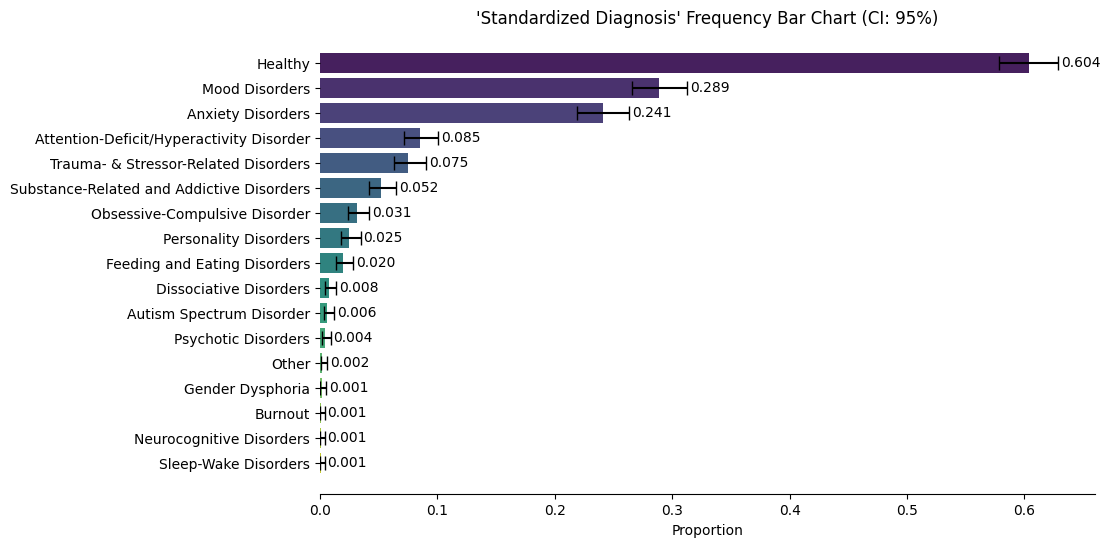

In [64]:
unique_diagnoses = mental_health_da_df.copy()
unique_diagnoses["standardized_diagnosis"] = unique_diagnoses[
    "standardized_diagnosis"
].str.split("|")
unique_diagnoses = unique_diagnoses.explode("standardized_diagnosis")
unique_diagnoses

univariate_barplot_with_wilson_score_intervals(
    categorical_data_series=unique_diagnoses["standardized_diagnosis"],
    proportional=True,
    sort_by_frequency_asc=(True, False),
)

This graph displays the proportions of the most common mental disorders in the sample. The three most prevalent disorders are Mood Disorders, Anxiety Disorders, and Attention-Deficit/Hyperactivity Disorder (ADHD, hereafter). A key limitation of this graph is that it treats each group as entirely independent, which does not reflect the overlap that exists in the sample.

In future analyses, it would be beneficial to separate diagnoses into distinct categories for unique cases, while keeping only the intersections as combined categories. Researches have shown that ADHD cases lead to higher depression Depression rates, underscoring the importance of representing these overlaps accurately.

#### Frequency Visualization of "Standardized Diagnosis" Feature (Top 7 Groups)

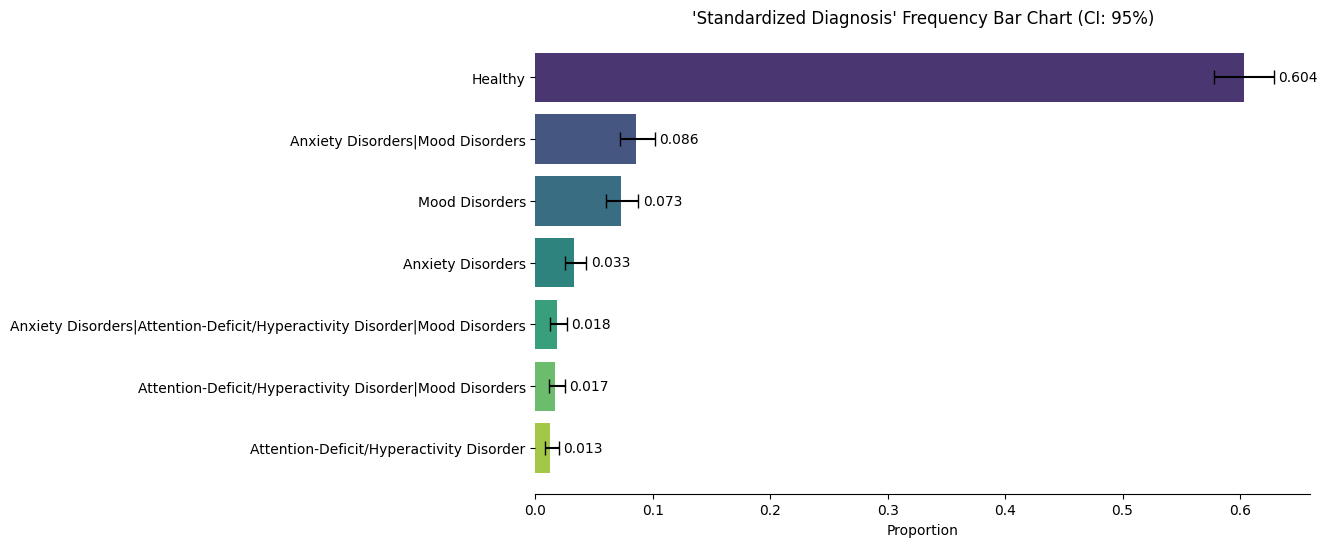

In [65]:
filtered_top_diagnoses = mental_health_da_df[
    mental_health_da_df["standardized_diagnosis"].isin(
        mental_health_da_df["standardized_diagnosis"].value_counts().nlargest(7).index
    )
]

univariate_barplot_with_wilson_score_intervals(
    filtered_top_diagnoses["standardized_diagnosis"],
    True,
)

It is evident that Anxiety and Mood Disorders often coexist, creating a negative feedback loop that exacerbates each condition (as supported by academic research). Similarly, Attention-Deficit/Hyperactivity Disorder (ADHD) frequently appears alongside other disorders, particularly Anxiety and Mood Disorders, rather than as an isolated diagnosis, highlighting the interconnectedness of these mental health conditions (a relationship also supported by research).

#### Frequency Visualization of "Age Groups" Feature 

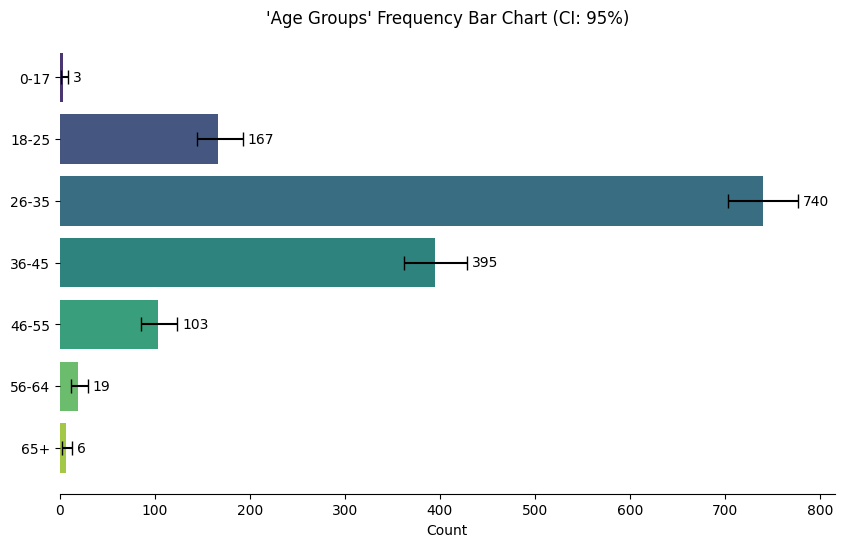

In [66]:
univariate_barplot_with_wilson_score_intervals(mental_health_da_df["age_groups"])

The majority of participants are between 18 and 55 years old, with very few individuals in the other age groups. As a result, the sample provides limited representation for comparisons between diagnosis ~ age.

#### Frequency Visualization of "Standardized Gender" Feature 

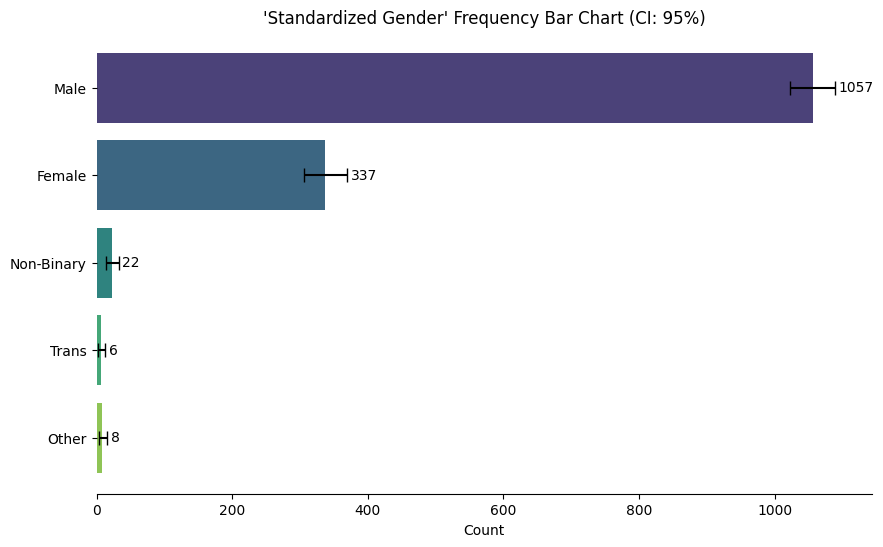

In [67]:
univariate_barplot_with_wilson_score_intervals(
    mental_health_da_df["standardized_gender"]
)

The majority of participants are cis- males and females, with very small groups of non-binary individuals, transgender individuals, and others, making these latter groups less representative in the sample.

#### Frequency Visualization of "Country" Feature 

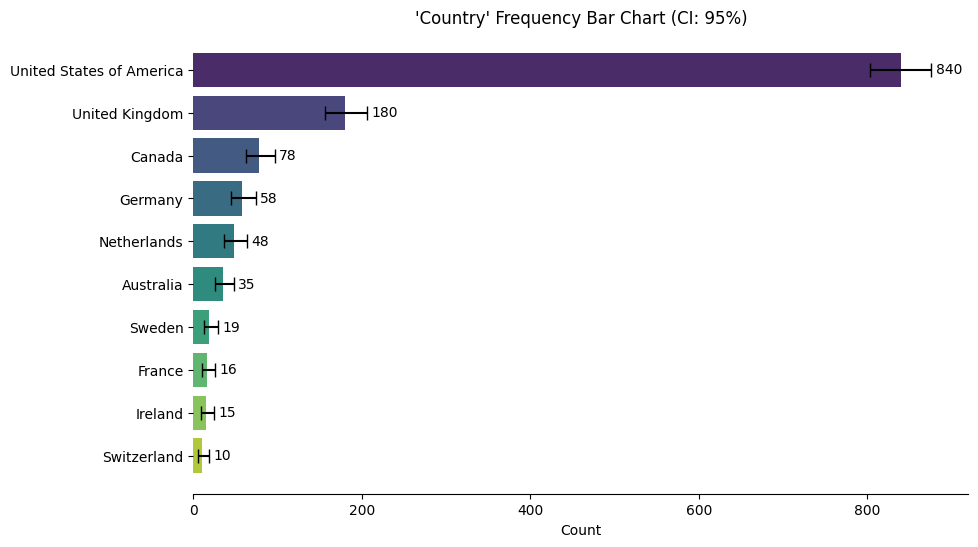

In [68]:
filtered_top_countries = mental_health_da_df[
    mental_health_da_df["country"].isin(
        mental_health_da_df["country"].value_counts().nlargest(10).index
    )
]

univariate_barplot_with_wilson_score_intervals(filtered_top_countries["country"])

Most participants are from the USA; however, there are also several other countries with a substantial number of participants.

#### Frequency Visualization of "Country Freedom Level" Feature 

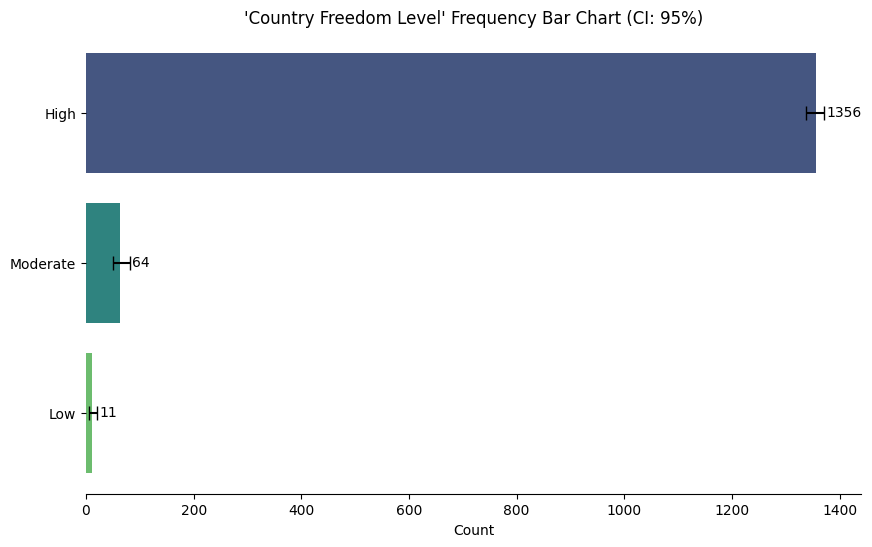

In [69]:
univariate_barplot_with_wilson_score_intervals(
    mental_health_da_df["country_freedom_level"]
)

I attempted to create a new feature to enhance representation and provide better insights for comparing diagnosis with country freedom levels, but unfortunately the representation worsen. We can at least conclude that most of the participants are from high freedom level countries according to The Cato Institute (2016).

#### Frequency Visualization of "Position" Feature 

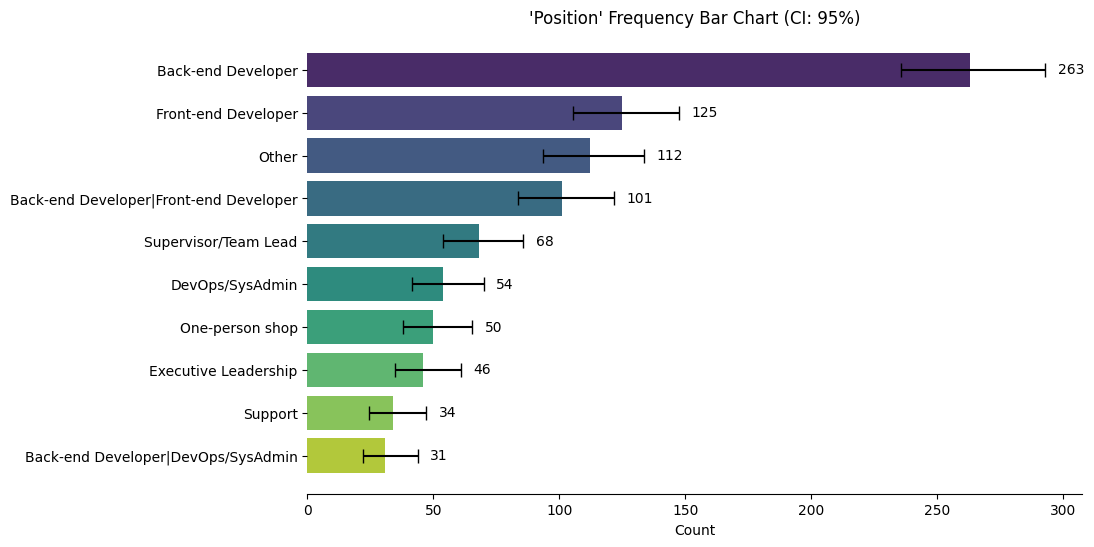

In [70]:
filtered_top_positions = mental_health_da_df[
    mental_health_da_df["position"].isin(
        mental_health_da_df["position"].value_counts().nlargest(10).index
    )
]

univariate_barplot_with_wilson_score_intervals(
    mental_health_da_df[
        mental_health_da_df["position"].isin(
            mental_health_da_df["position"].value_counts().nlargest(10).index
        )
    ]["position"]
)

The "position" feature offers a good representation among features, with fairly balanced numbers across various tech job roles. Given the large variety of positions, I'll need to select the most relevant ones for further analysis.

#### Frequency Visualization of "Employees Count" Feature 

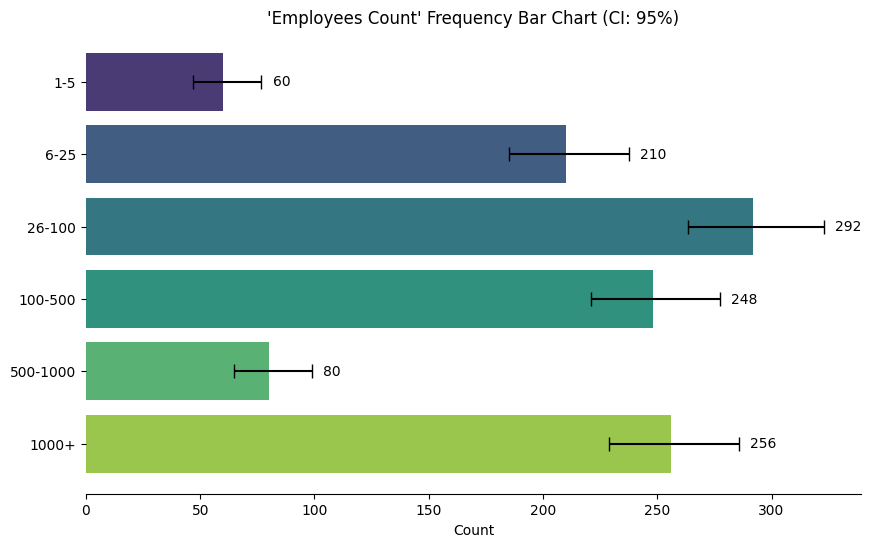

In [71]:
univariate_barplot_with_wilson_score_intervals(mental_health_da_df["employees_count"])

Another fairly representative chart displays the employee count for participants' jobs. Interestingly, the 500-1000 employee group is notably smaller compared to the adjacent groups.

#### Frequency Visualization of "Self Employed" Feature 

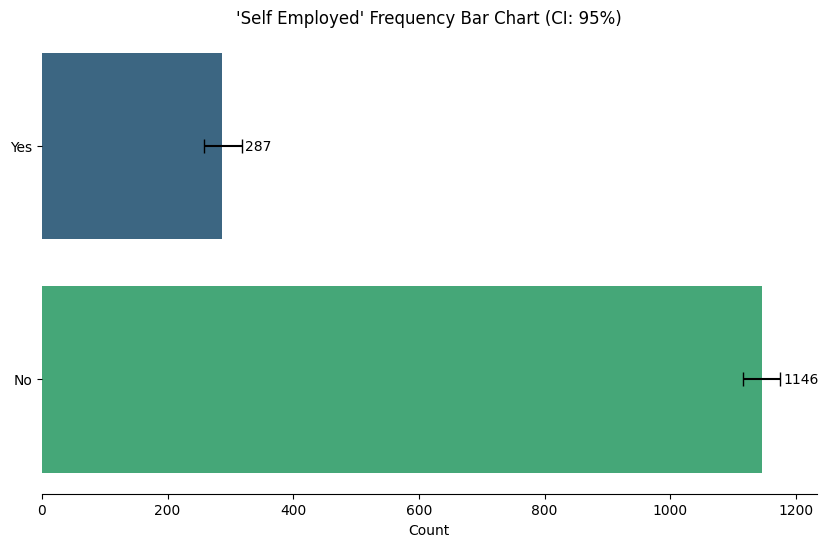

In [72]:
univariate_barplot_with_wilson_score_intervals(mental_health_da_df["self_employed"])

Although the proportional difference is not small, the count of participants in the "self-employed" category is substantial for meaningful further analysis.

#### Frequency Visualization of "Working Remotely" Feature 

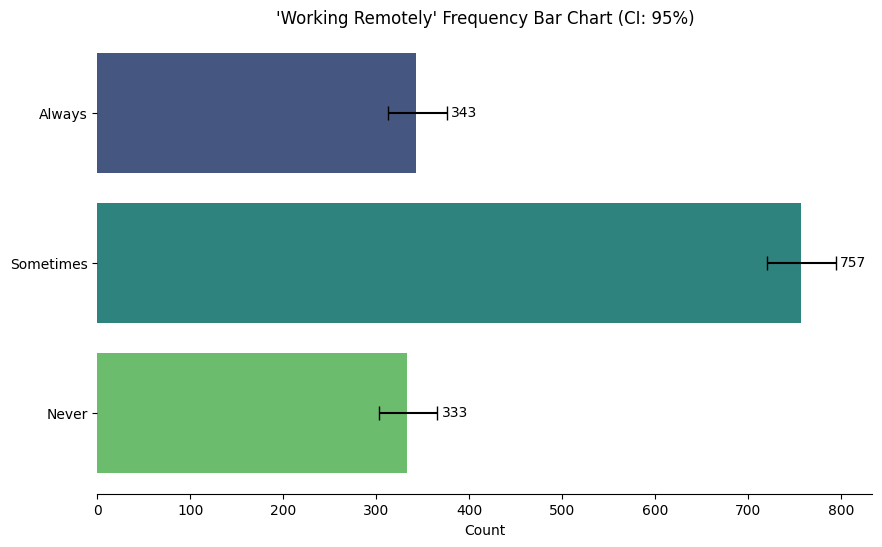

In [73]:
univariate_barplot_with_wilson_score_intervals(mental_health_da_df["working_remotely"])

The "working remotely" feature has a good representation of groups for analysis.

#### Frequency Visualization of "Family Illness History" Feature 

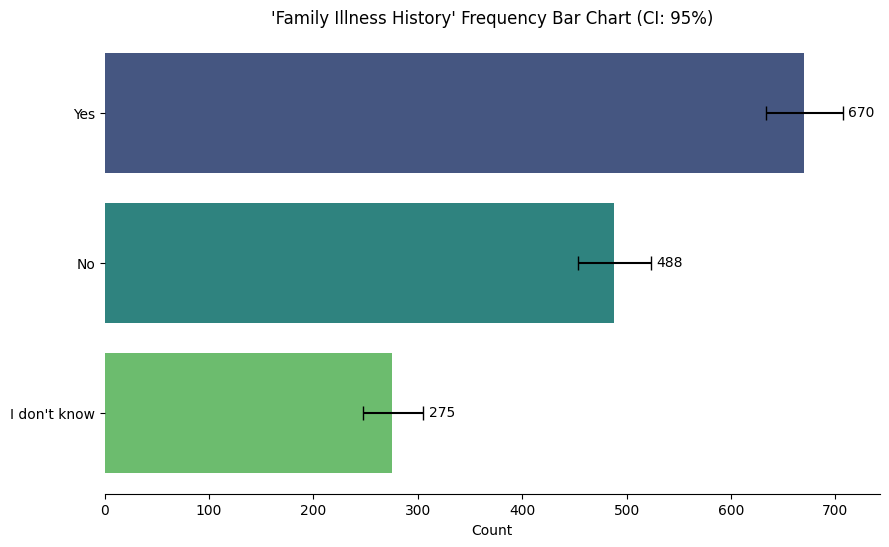

In [74]:
univariate_barplot_with_wilson_score_intervals(
    mental_health_da_df["family_illness_history"]
)

The "family illness history" feature has a good representation of groups for analysis.

#### Frequency Visualization of "Derived Willingness to Share" Feature 

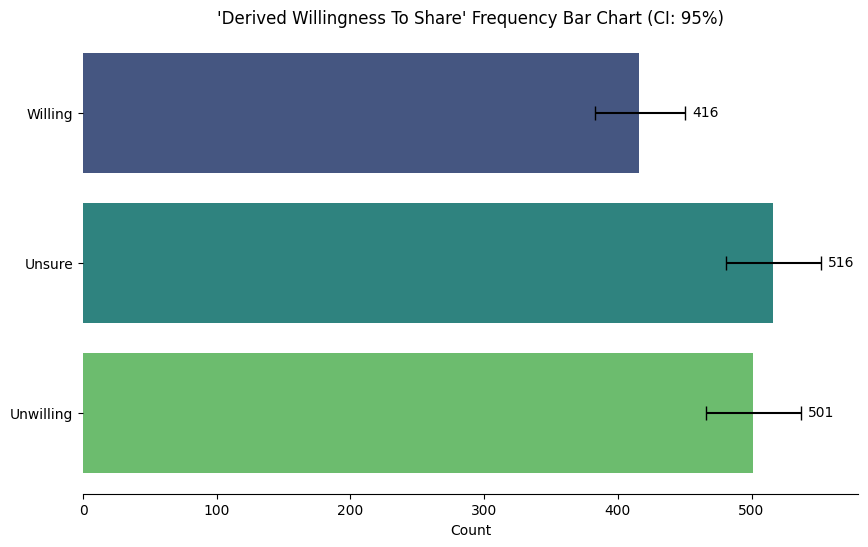

In [75]:
univariate_barplot_with_wilson_score_intervals(
    mental_health_da_df["derived_willingness_to_share"]
)

The graph shows that the derived values for the "Willingness to Share" feature, which combines responses from multiple questions related to openness about sharing mental health issues, are represented well. The key question, however, is whether my derivation of the combined values is realistic to some extent.

#### Frequency Visualization of "Derived Workplace Attitude" Feature 

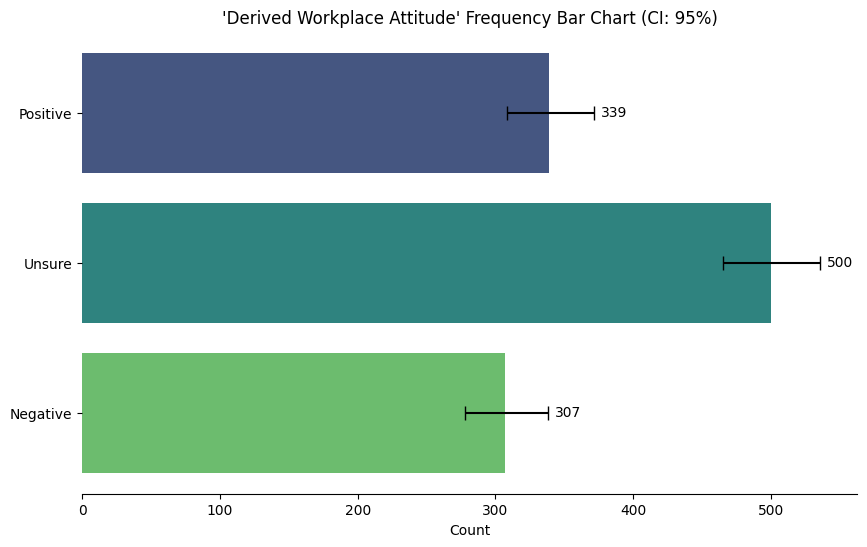

In [76]:
univariate_barplot_with_wilson_score_intervals(
    mental_health_da_df["derived_workplace_attitude"]
)

The graph indicates that the derived values for the "Workplace Attitude" feature, which combines responses from multiple questions related to attitudes towards mental health issues in the workplace, are as well representative. The key question remains whether my method of deriving these combined values is realistic to some extent.

#### Frequency Visualization of "Derived Mental Health Disclosure Negative Impact" Feature 

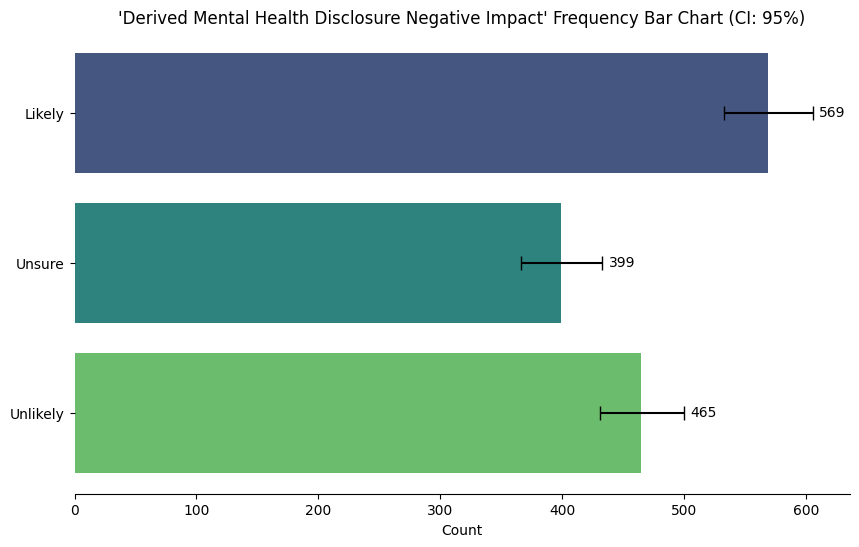

In [77]:
univariate_barplot_with_wilson_score_intervals(
    mental_health_da_df["derived_mental_health_disclosure_negative_impact"]
)

The graph indicates that the derived values for the "Mental Health Disclosure Negative Impact" feature, which combines responses from multiple questions regarding how likely mental health issues negatively affect individuals, are similarly well-represented. The key question remains whether my method of deriving these combined values is realistic to some extent.

### $Cramér's\ V$ Statistic for Categorical Variables

For further analysis, I will focus on examining relationships between features and four selected groups of "standardized_diagnosis" feature: "Healthy," "Anxiety Disorders," "Mood Disorders," and "ADHD."

#### Function for $Cramér's\ V$ statistic 

In [78]:
def cramers_v(confusion_matrix: pd.DataFrame) -> list[float, float]:
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1))), p

#### Creation of Tables Containing Groups of Interest

I need to determine if single diagnoses can be meaningfully combined with those that include multiple diagnoses (combinations of "Anxiety Disorders," "Mood Disorders," and "ADHD")

In [79]:
single_diagnosis_groups_of_interest = [
    "Healthy",
    "Anxiety Disorders",
    "Mood Disorders",
    "Attention-Deficit/Hyperactivity Disorder",
]
combined_and_single_diagnosis_groups_of_interest = [
    "Healthy",
    "Anxiety Disorders",
    "Mood Disorders",
    "Attention-Deficit/Hyperactivity Disorder",
    "Anxiety Disorders|Mood Disorders",
    "Anxiety Disorders|Attention-Deficit/Hyperactivity Disorder",
    "Attention-Deficit/Hyperactivity Disorder|Mood Disorders",
    "Anxiety Disorders|Attention-Deficit/Hyperactivity Disorder|Mood Disorders",
]
combined_diagnosis_groups_of_interest = [
    "Healthy",
    "Anxiety Disorders|Mood Disorders",
    "Anxiety Disorders|Attention-Deficit/Hyperactivity Disorder",
    "Attention-Deficit/Hyperactivity Disorder|Mood Disorders",
    "Anxiety Disorders|Attention-Deficit/Hyperactivity Disorder|Mood Disorders",
]

filtered_single_diagnosis_groups_df = mental_health_da_df[
    mental_health_da_df["standardized_diagnosis"].isin(
        single_diagnosis_groups_of_interest
    )
]
filtered_combined_and_single_diagnosis_groups_df = mental_health_da_df[
    mental_health_da_df["standardized_diagnosis"].isin(
        combined_and_single_diagnosis_groups_of_interest
    )
]
filtered_combined_diagnosis_groups_df = mental_health_da_df[
    mental_health_da_df["standardized_diagnosis"].isin(
        combined_diagnosis_groups_of_interest
    )
]

#### Calculation of $Cramér's\ V$ statistic

In [80]:
categorical_features = mental_health_da_df.iloc[:, 1:].columns.tolist()
ordered_diagnosis_features = [
    "Unfiltered Diagnosis Groups",
    "Single Diagnosis Groups of Interest",
    "Combined and Single Diagnosis Groups of Interest",
    "Combined Diagnosis Groups of Interest",
]
ordered_dfs_for_diagnosis_features = [
    mental_health_da_df,
    filtered_single_diagnosis_groups_df,
    filtered_combined_and_single_diagnosis_groups_df,
    filtered_combined_diagnosis_groups_df,
]

p_value_matrix = pd.DataFrame(
    index=categorical_features,
    columns=ordered_diagnosis_features,
    dtype=float,
)
cramers_v_matrix = pd.DataFrame(
    index=categorical_features,
    columns=ordered_diagnosis_features,
    dtype=float,
)

# Calculate Cramér's V values and p-values for each categorical feature and diagnosis group
for feature in categorical_features:
    for group, df in zip(
        ordered_diagnosis_features,
        ordered_dfs_for_diagnosis_features,
    ):
        if feature == "standardized_diagnosis":
            p_value_matrix.loc[feature, group] = 1.0
            cramers_v_matrix.loc[feature, group] = 1.0
        else:
            contingency_table = pd.crosstab(df[feature], df["standardized_diagnosis"])
            cv, p = cramers_v(contingency_table)
            p_value_matrix.loc[feature, group] = p
            cramers_v_matrix.loc[feature, group] = cv

cramers_v_matrix.round(2)

,Unfiltered Diagnosis Groups,Single Diagnosis Groups of Interest,Combined and Single Diagnosis Groups of Interest,Combined Diagnosis Groups of Interest
age_groups,0.30,0.06,0.08,0.09
standardized_gender,0.48,0.09,0.11,0.10
country,0.26,0.18,0.15,0.14
country_freedom_level,0.33,0.08,0.09,0.06
position,0.41,0.37,0.37,0.39
employees_count,0.27,0.08,0.09,0.08
self_employed,0.31,0.03,0.06,0.06
working_remotely,0.28,0.07,0.08,0.05
standardized_diagnosis,1.00,1.00,1.00,1.00
family_illness_history,0.35,0.18,0.24,0.22


In [81]:
p_value_matrix.round(2)

,Unfiltered Diagnosis Groups,Single Diagnosis Groups of Interest,Combined and Single Diagnosis Groups of Interest,Combined Diagnosis Groups of Interest
age_groups,0.00,0.95,0.35,0.07
standardized_gender,0.00,0.01,0.00,0.00
country,1.00,1.00,1.00,1.00
country_freedom_level,0.00,0.06,0.10,0.43
position,0.00,0.84,0.55,0.29
employees_count,0.68,0.45,0.38,0.37
self_employed,0.03,0.88,0.80,0.52
working_remotely,0.37,0.16,0.39,0.75
standardized_diagnosis,1.00,1.00,1.00,1.00
family_illness_history,0.00,0.00,0.00,0.00


#### Heatmap of $Cramér's\ V$ Statistic

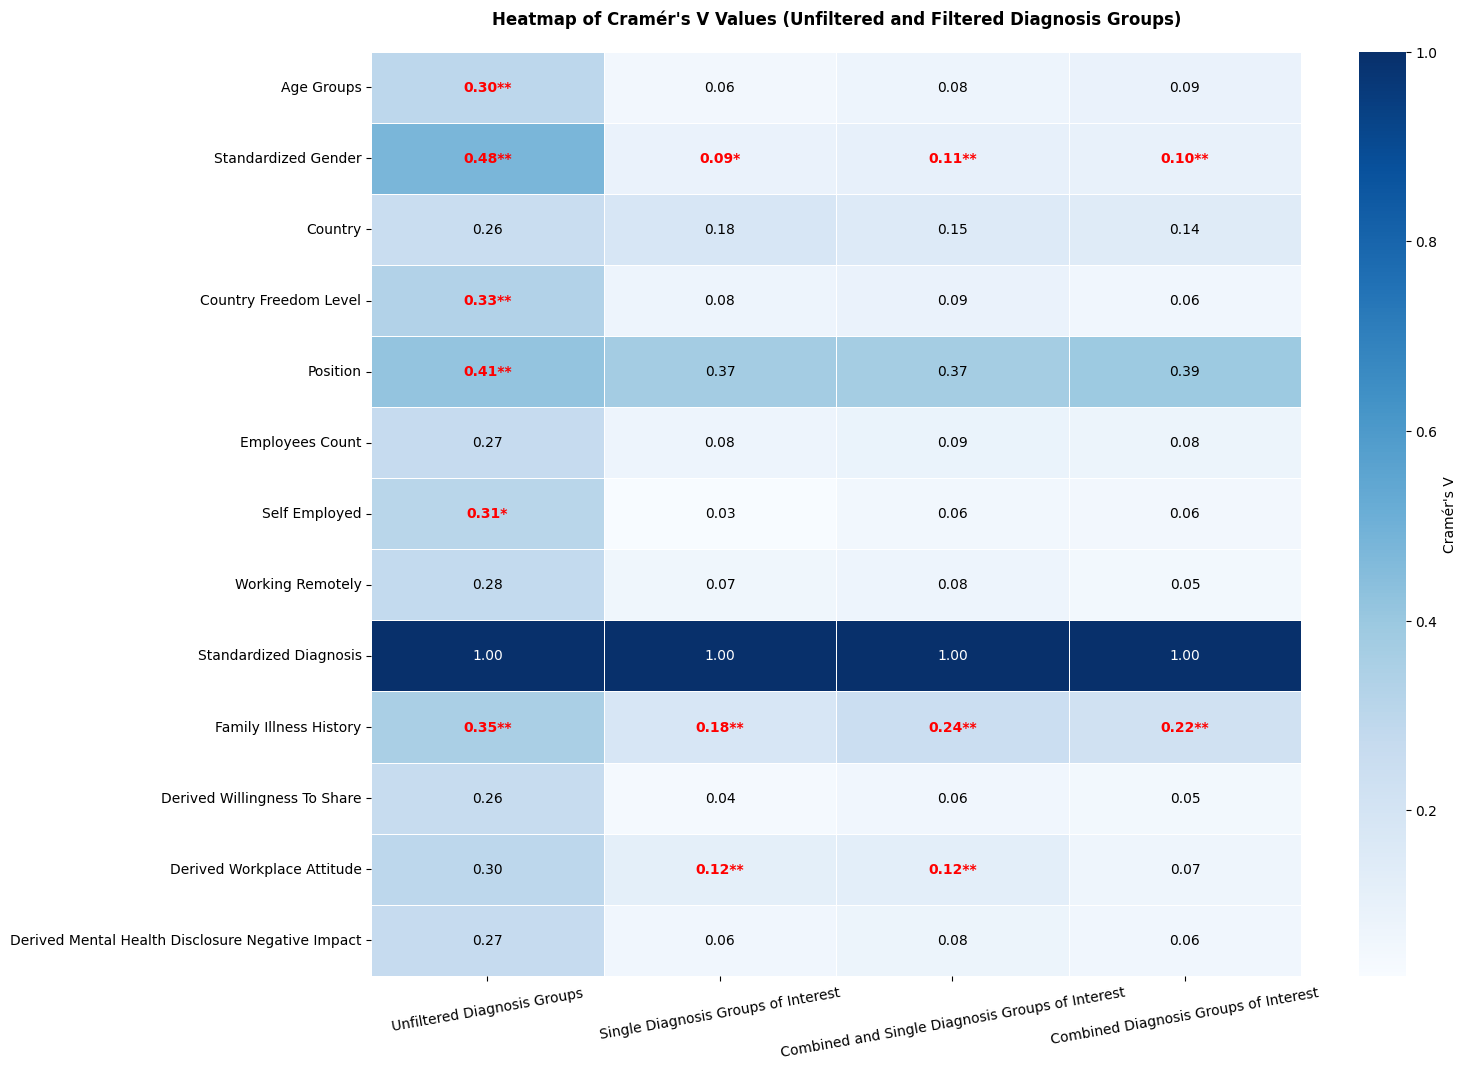

In [82]:
plt.figure(figsize=(15, 12))
sns.heatmap(
    data=cramers_v_matrix,
    linewidths=0.5,
    cmap=sns.color_palette("Blues", as_cmap=True),
    yticklabels=[label.replace("_", " ").title() for label in categorical_features],
    cbar_kws={"label": "Cramér's V"},
)

# Annotate the heatmap with the association coefficients and p-values
for i in range(cramers_v_matrix.shape[0]):
    for j in range(cramers_v_matrix.shape[1]):
        value = cramers_v_matrix.iloc[i, j]
        p_value = p_value_matrix.iloc[i, j]

        if p_value < 0.01:
            annotation = f"{value:.2f}**"
            font_properties = {"size": 10, "weight": "bold", "color": "red"}
        elif p_value < 0.05:
            annotation = f"{value:.2f}*"
            font_properties = {"size": 10, "weight": "bold", "color": "red"}
        elif p_value == 1:
            annotation = f"{value:.2f}"
            font_properties = {"size": 10, "color": "white"}
        else:
            annotation = f"{value:.2f}"
            font_properties = {"size": 10}

        plt.text(
            j + 0.5,
            i + 0.5,
            annotation,
            ha="center",
            va="center",
            **font_properties,
        )

plt.title(
    "Heatmap of Cramér's V Values (Unfiltered and Filtered Diagnosis Groups)",
    fontsize=12,
    fontweight="bold",
    loc="center",
    pad=20,
)
plt.xticks(rotation=10)

plt.show()

The differences between the unfiltered and filtered diagnosis groups are minimal, except for 'derived_workplace_attitude.' Therefore, to illustrate relationships, I will use the table 'filtered_combined_and_single_diagnosis_groups_df' which includes the filtered groups "Healthy," "Anxiety Disorders," "Mood Disorders," "Attention-Deficit/Hyperactivity Disorder," along with their combinations.

There are statistically significant associations between the filtered "Diagnosis" groups ("Healthy," "Anxiety Disorders," "Mood Disorders," and "ADHD") and the variables "Gender," "Family Illness History," and "Derived Workplace Attitude."

In contrast, the "Unfiltered Diagnosis Groups" demonstrate stronger associations overall, showing statistically significant relationships with "Age Groups" "Position" and "Country Freedom Level" too. However, they lack a significant association with "Derived Workplace Attitude." This suggests that the additional diagnoses outside the groups of interest may have distinct proportions or characteristics, which could impact the analysis.

The analysis could be improved by finding out what diagnoses have such an impact that "position" and "country freedom level" features starts to have statistically significant associations.

### Relationships Between Categorical Variables

Relationships between categorical variables will be shown for statistically significant associations.

#### Dataframe Preparation for Mosaic Plots

In [83]:
filtered_mental_health_da_df = filtered_combined_and_single_diagnosis_groups_df.copy()

filtered_mental_health_da_df["standardized_diagnosis"] = filtered_mental_health_da_df[
    "standardized_diagnosis"
].str.split("|")

filtered_mental_health_da_df = filtered_mental_health_da_df.explode(
    "standardized_diagnosis"
).reset_index(drop=True)

new_values = {
    "Healthy": "Healthy",
    "Anxiety Disorders": "Anxiety",
    "Mood Disorders": "Mood",
    "Attention-Deficit/Hyperactivity Disorder": "ADHD",
}

filtered_mental_health_da_df["standardized_diagnosis"] = filtered_mental_health_da_df[
    "standardized_diagnosis"
].replace(new_values)

filtered_mental_health_da_df["standardized_diagnosis"] = pd.Categorical(
    filtered_mental_health_da_df["standardized_diagnosis"],
    categories=(
        "Healthy",
        "Anxiety",
        "Mood",
        "ADHD",
    ),
    ordered=True,
)

I transformed the "standardized_diagnosis" combined diagnoses from a list-like format to separate rows, replicating index values. This transformation was intended to reduce the number of groups in the "standardized_diagnosis" feature.

Although combined values could be highly dependent, I proceeded with this approach because the Cramer's V statistic indicated negligible differences between groups.

#### Standardization of Mosaic Plot 

In [84]:
def standardized_mosaic_plot(
    data: pd.DataFrame, index: list[str], gap=0.02, label_rotation=0
) -> None:
    feature1, feature2 = [i.replace("_", " ").title() for i in index]
    title = f"Mosaic Plot of '{feature2}' vs. '{feature1}'"

    plt.rcParams["figure.figsize"] = [10, 8]

    mosaic(
        data=data,
        index=index,
        gap=gap,
        labelizer=lambda x: "",
        title=title,
        label_rotation=label_rotation,
    )

    plt.show()

### Mosaic Plot of "Standardized Diagnosis" vs. "Standardized Gender"

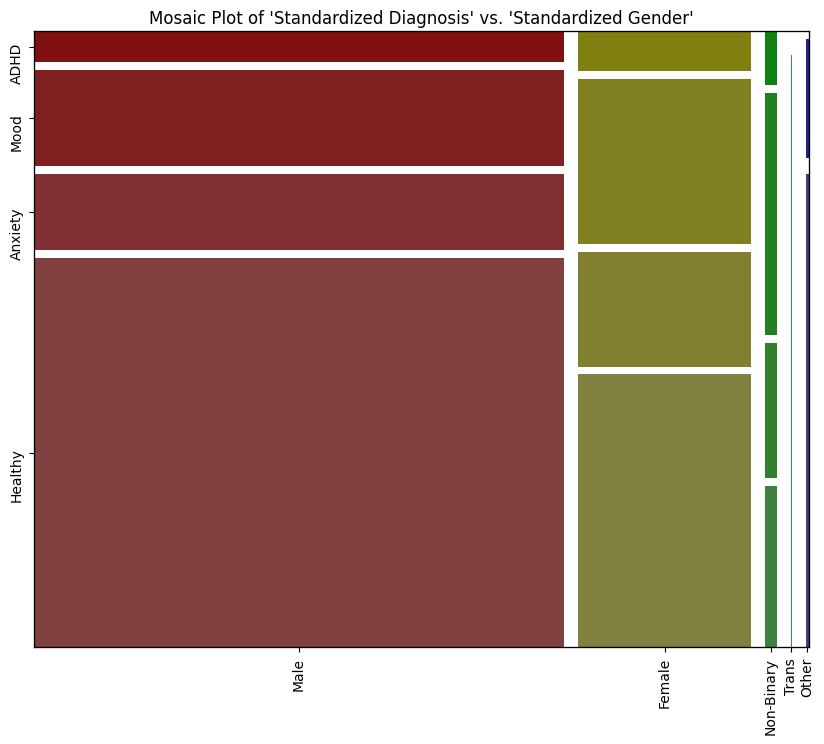

In [85]:
standardized_mosaic_plot(
    data=filtered_mental_health_da_df,
    index=["standardized_gender", "standardized_diagnosis"],
    label_rotation=90,
)

There is a clear increase in mental disorders among cis-females and other gender groups. 

To address the under-representation of non-binary, trans, and other gender identities, I create a separate feature grouping these categories together. This grouping should reflect the possibility that they may face similar challenges, such as discrimination, which could contribute to the higher prevalence of mental health issues in these groups.

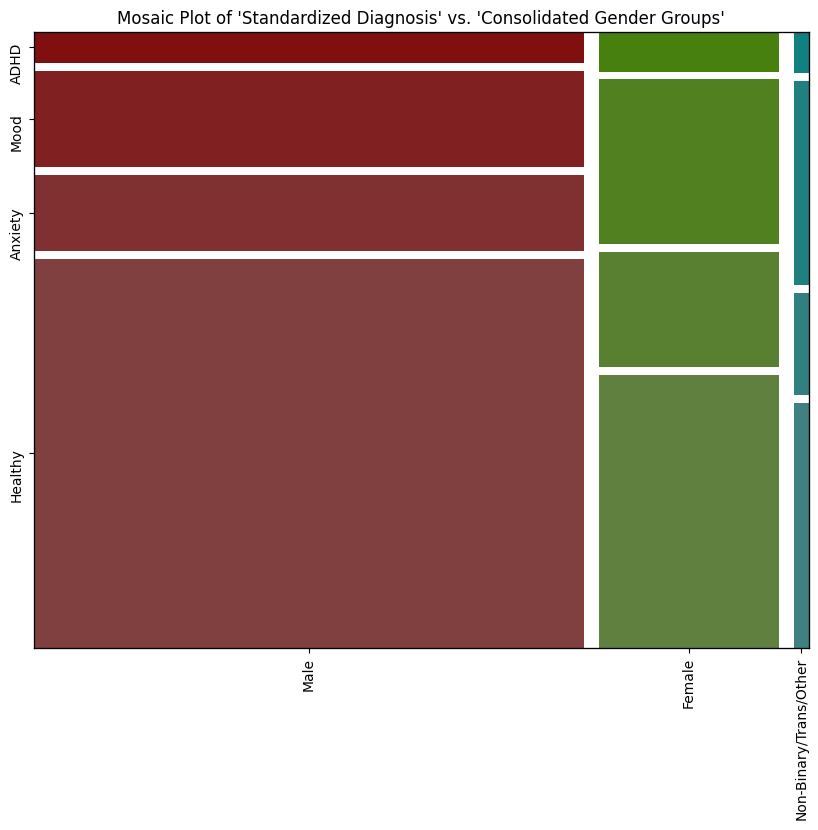

In [86]:
filtered_mental_health_da_df["consolidated_gender_groups"] = (
    filtered_mental_health_da_df["standardized_gender"]
    .astype(pd.StringDtype())
    .replace(
        {
            "Non-Binary": "Non-Binary/Trans/Other",
            "Trans": "Non-Binary/Trans/Other",
            "Other": "Non-Binary/Trans/Other",
        }
    )
)

standardized_mosaic_plot(
    data=filtered_mental_health_da_df,
    index=["consolidated_gender_groups", "standardized_diagnosis"],
    label_rotation=90,
)

After merging three small groups into one we could still see the difference and clear as day increase in mood disorders for women and for Non-Binary/Trans/Other even more. Interestingly ADHD remains at a quite similar level, this could be related more with genetic inheritance rather then environmental pressures. This conclusion will be derived from "Standardized Diagnosis" vs. "Family Illness History" plot too.

### Mosaic Plot of "Standardized Diagnosis" vs. "Family Illness History"

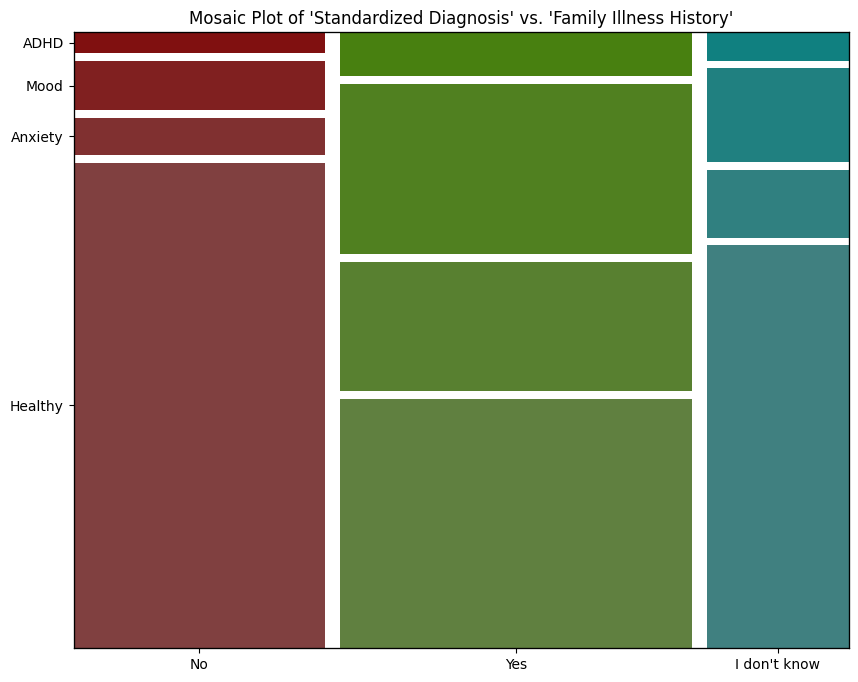

In [87]:
standardized_mosaic_plot(
    data=filtered_mental_health_da_df,
    index=["family_illness_history", "standardized_diagnosis"],
)

In the "Standardized Diagnosis" vs. "Family Illness History" plot, the impact of genetic inheritance on mental health disorders is clearly evident. The "I don't know" group serves as a middle ground between participants who are aware of mental health conditions in their family and those who are not. In this group, the prevalence rate of mental disorders is higher, but not significantly so.

### Mosaic Plot of "Standardized Diagnosis" vs. "Derived Workplace Attitude"

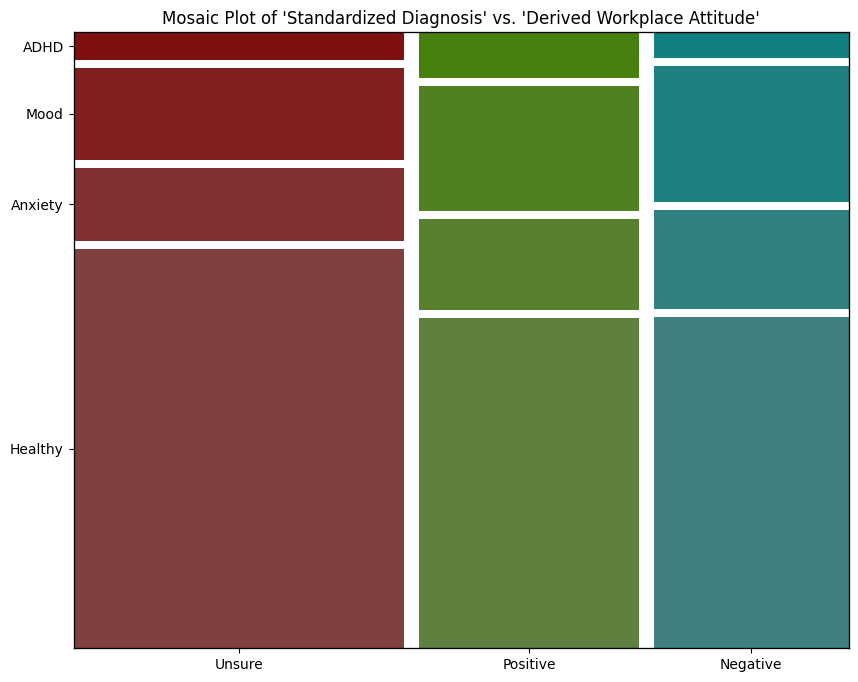

In [88]:
standardized_mosaic_plot(
    data=filtered_mental_health_da_df,
    index=["derived_workplace_attitude", "standardized_diagnosis"],
)

In the "Standardized Diagnosis" vs. "Derived Workplace Attitude" plot, participants who are uncertain about their workplace’s attitude toward mental health disorders appear more likely to be healthy. This may be because they don’t feel affected by their workplace environment's stance, possibly due to not experiencing mental health issues themselves.

### Mosaic Plot of "Standardized Diagnosis" vs. "Country Freedom Level" ($p$-value = 0.1)

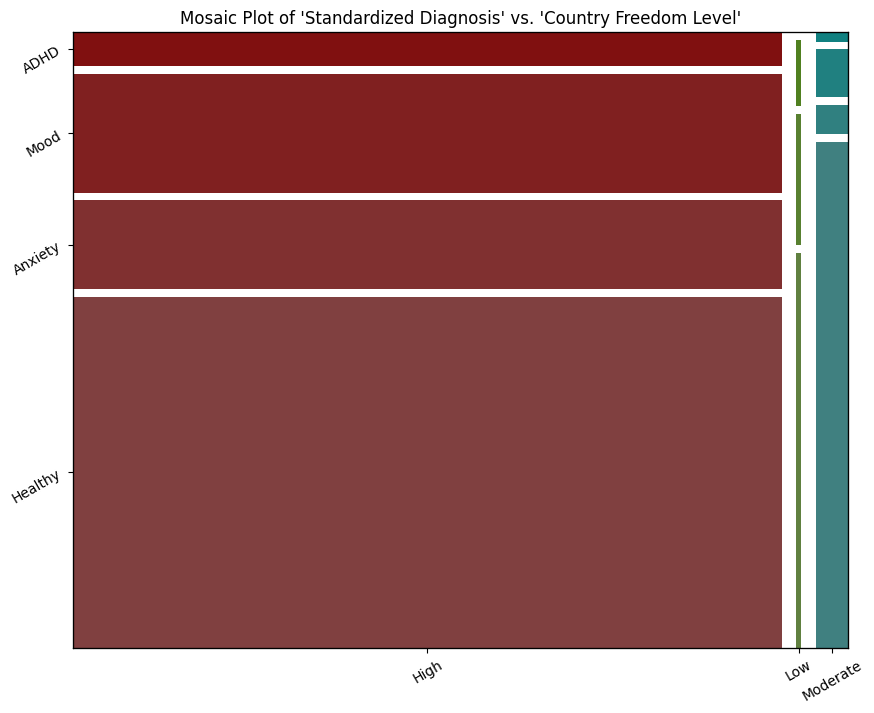

In [89]:
standardized_mosaic_plot(
    data=filtered_mental_health_da_df,
    index=["country_freedom_level", "standardized_diagnosis"],
    label_rotation=30,
)

Although the $p$-value of 0.1 is somewhat high (clearly visible that sample lack adequate representation), the trend is still evident: countries with "Low" and "Moderate" freedom levels have lower proportions of the diagnoses of interest. This could potentially be due to fears of discrimination associated with mental health diagnoses in these regions.

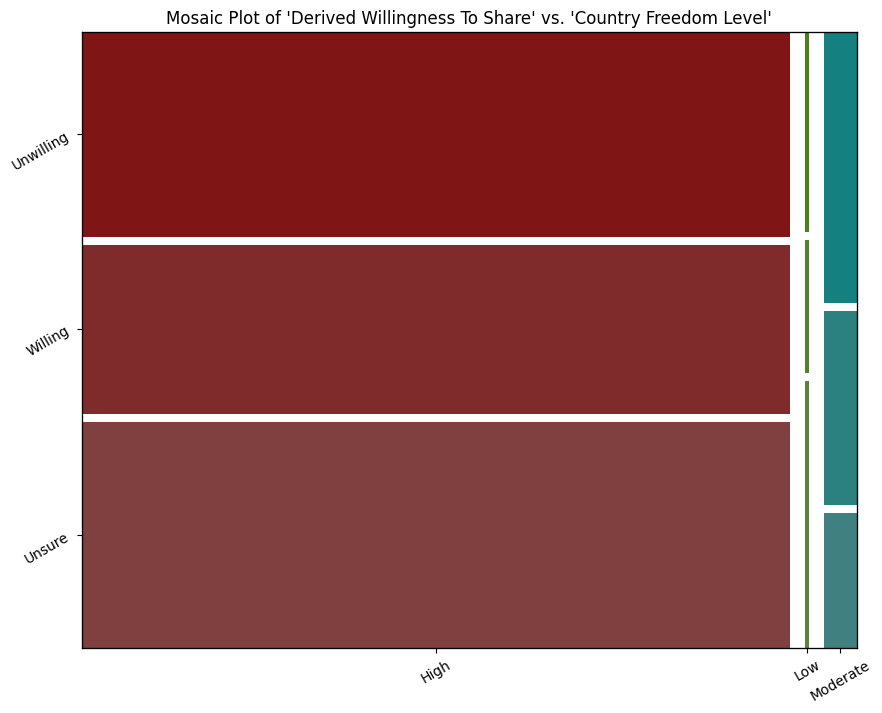

In [90]:
standardized_mosaic_plot(
    data=filtered_mental_health_da_df,
    index=["country_freedom_level", "derived_willingness_to_share"],
    label_rotation=30,
)

The reluctance to discuss mental health issues is evident in this mosaic plot, which shows that participants from moderate freedom-level countries are less willing to talk about mental health. This could be partly explained by the stigma surrounding mental health conditions in these regions.

## Prevalence Rate for Diagnoses of Interest

### Individual Prevalence Rates for Each Disorder of Interest

In [91]:
get_matching_value_counts(
    mental_health_da_df["standardized_diagnosis"],
    [
        "Mood Disorders",
        "Anxiety Disorders",
        "Attention-Deficit/Hyperactivity Disorder",
    ],
) / mental_health_da_df.shape[0]

Mood Disorders                              0.288904
Anxiety Disorders                           0.240754
Attention-Deficit/Hyperactivity Disorder    0.085136
dtype: float64

Individual prevalence rates for each disorder of interest:

- Mood: 0.29 (29%)

- Anxiety: 0.24 (24%)

- ADHD: 0.085 (8.5%)

### Total Prevalence Rate for Diagnoses of Interest

In [92]:
mental_health_da_df["standardized_diagnosis"].str.contains(
    "Mood Disorders|Anxiety Disorders|Attention-Deficit/Hyperactivity Disorder"
).value_counts() / mental_health_da_df.shape[0]

standardized_diagnosis
False    0.629449
True     0.370551
Name: count, dtype: Float64

Total prevalence rate of the sample is **~37%** for Mood Disorders, Anxiety Disorders, and ADHD.

## Overview of Analyzed Sample (2016 survey)

The sample size of the 2016 survey: **1433**

Sociodemographic features that I used for analysis: 
- age

- gender

- country

- family illness history

Did not use:
- race


**Sampling Biases:**

- Selection Bias: The sample lacks geographical diversity, with most survey responses coming from the US and UK and very few from "third countries." However, age and gender are reasonably represented, despite fewer women participating (reflecting the current gender distribution in the tech industry). This is consistent with data available in various public sources.

    - Convenience Bias also influenced the sample. The country representation indicates that most participants likely understand English, as all questions were presented in English. This may have excluded non-English speakers who were unable to respond. It’s likely that limited funding prevented translating the survey or establishing contacts in “third countries.” In the "Standardized Diagnosis" vs. "Country Freedom Level" analysis, countries with low and moderate freedom levels show a clear distinction in mental health diagnoses.

- Voluntary Response Bias: As a survey, it’s unclear (could not find methodology of survey) if participants self-selected into the survey. However, the sample size is quite large, so by the Central Limit Theorem (CLT), the sample mean likely approximates the true population mean. Thus, voluntary response bias should have a limited impact on the results.